<a href="https://colab.research.google.com/github/naryst/toxic_comments_classification/blob/master/Model_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook i will train the model that i will try to attack. 

The model is classify toxic comments using BERT.


# Let's install needed files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1m5tntO0mes-eduC1n-6egKyFethVRqKm' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1m5tntO0mes-eduC1n-6egKyFethVRqKm" -O train_data.zip && rm -rf /tmp/cookies.txt
!unzip train_data.zip
!unzip train.csv.zip;

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 75.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 24.3 MB/s eta 0:00:00
--2023-04-08 19:15:15--  https://docs.google.com/uc?export=download&confirm=t&id=1m5tntO0mes-eduC1n-6egKyFethVRqKm
Resolving docs.google.com (docs.google.com)... 74.125.126.139, 74.125.126.101, 74.125.126.138, ...
Connecting to docs.google.com (docs.google.com)|74.125.126.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-4o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/n38fgh0ft7s506vbfv9sm4uci7sj4tcd/1680981300000/14432876042194918988/*/1m5tntO0mes-eduC1n-6egKyFethVRqKm?e=download&uuid=05b6fa73-6bc9-4027-baac-d2d1a2b61623 [following]
--2023-04-08 19:15:15--  https://doc-00-4

In [ ]:

import pandas as pd
import numpy as np
import re

import torch
import torch.nn as nn
import torch.optim as optim

from transformers import BertTokenizer, BertModel

from tqdm import tqdm
import os

device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda:0')

In [ ]:
print("CUDA is available:", torch.cuda.is_available())

CUDA is available: True


# Data preprocessing

In [ ]:
path = "./"
COLAB_PATH = "/content/drive/MyDrive/NLP/"

Firstly, let's check our dataset.

In [ ]:
import os

train_df = pd.read_csv(os.path.join(path, 'train.csv'))
train_df = train_df.drop(['severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'], axis=1)
train_df['non_toxic'] = 1 - train_df['toxic']
train_df.head(10)

,id,comment_text,toxic,non_toxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,1
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,1
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,1
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,1
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,1
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,1
9,00040093b2687caa,alignment on this subject and which are contra...,0,1


Lets look on the amount of samples of each class in the dataset with histograms. 

9.433568719759382


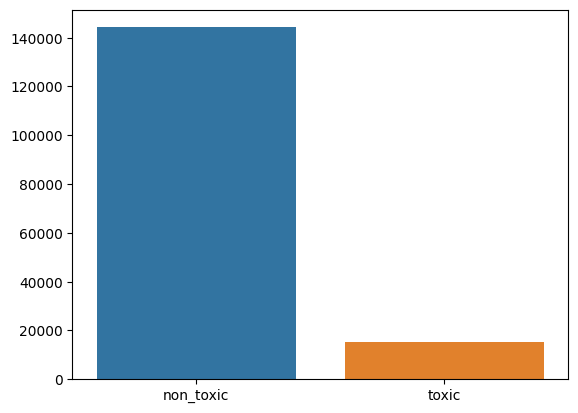

In [ ]:
import seaborn as sns
toxic_num = train_df[train_df['toxic'] == 1].shape[0]
nontoxic_num = train_df[train_df['non_toxic'] == 1].shape[0]
sns.barplot(x=['non_toxic', 'toxic'], y=[nontoxic_num, toxic_num])
print(nontoxic_num / toxic_num)

As we can see, classes are imbalansed (number of nontoxic comments ~9.5 time greater then number of toxic samples. So, we should deal with it somehow while splitting data into train and test sets to balance classes.

In [ ]:
train_df["length"] = train_df["comment_text"].str.split().apply(len)

In [ ]:
train_df["length"].describe()

count    159571.000000
mean         67.273527
std          99.230702
min           1.000000
25%          17.000000
50%          36.000000
75%          75.000000
max        1411.000000
Name: length, dtype: float64

In [ ]:
train_df.shape

(159571, 5)

Divide it into train and validation datasets.

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_valid = train_test_split(train_df, test_size=0.2, stratify=train_df["toxic"])

In [ ]:
df_train = pd.concat(
        [
            df_train[df_train["toxic"] == 0].sample(
                5000, random_state=199, replace=False
            ),
            df_train[df_train["toxic"] == 1].sample(
                5000, random_state=199, replace=False
            ),
        ]
    )
df_valid = pd.concat(
        [
            df_valid[df_valid["toxic"] == 0].sample(
                500, random_state=199, replace=False
            ),
            df_valid[df_valid["toxic"] == 1].sample(
                500, random_state=199, replace=False
            ),
        ]
    )

In [ ]:
df_train.shape, df_valid.shape

((10000, 5), (1000, 5))

We ideally want our dataset code to be decoupled from our model training code for better readability and modularity. Let's use PyTorch's data primitives: ```torch.utils.data.DataLoader``` and ```torch.utils.data.Dataset```.

And here is the example how Bert tokenizer works

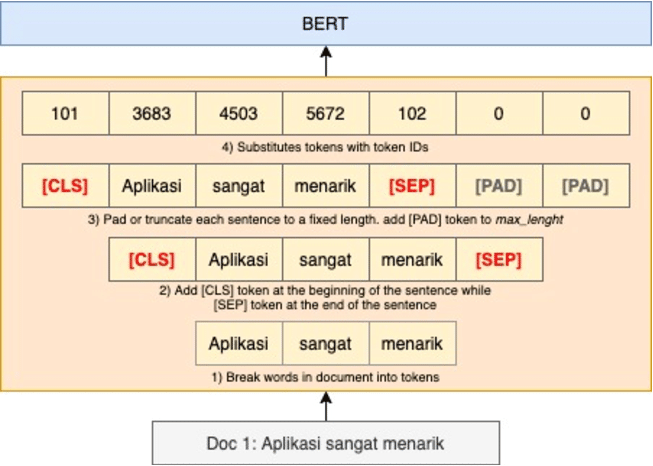

In [ ]:
from torch.utils.data import Dataset, DataLoader, RandomSampler

def clear_str(string):
    """
    Tokenization/string cleaning for text
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`\.]", " ", string)
    string = re.sub(r"\'s", " 's", string)
    string = re.sub(r"\'ve", " 've", string)
    string = re.sub(r"n\'t", " n't", string)
    string = re.sub(r"\'d", " 'd", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"\.", " . ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " ( ", string)
    string = re.sub(r"\)", " ) ", string)
    string = re.sub(r"\?", " ? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

class ToxicDataset(Dataset):
    
    def __init__(self, tokenizer: BertTokenizer, dataframe: pd.DataFrame):
        self.tokenizer = tokenizer
        self.pad_idx = tokenizer.pad_token_id
        self.df = dataframe        
    
    @staticmethod
    def row_to_tensor(tokenizer: BertTokenizer, row: pd.Series):
        tokens = tokenizer.encode(clear_str(row["comment_text"]), add_special_tokens=True)
        tokens = tokens[:119] + [tokens[-1]] if len(tokens) > 120 else tokens
        x = torch.LongTensor(tokens)

        labels = ['non_toxic', 'toxic']
        y = torch.FloatTensor(row[labels])
        return x, y

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index: int):
        return self.row_to_tensor(self.tokenizer, self.df.iloc[index])

In [ ]:
from functools import partial
from torch.nn.utils.rnn import pad_sequence

# merges a list of samples to form a mini-batch of Tensors
def collate_fn(batch, device: torch.device):
    x, y = list(zip(*batch))
    x = pad_sequence(x, batch_first=True, padding_value=0)
    y = torch.stack(y)
    return x.to(device), y.to(device)

collate_fn = partial(collate_fn, device=device)

In [ ]:
bert_model_name = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

train_dataset = ToxicDataset(tokenizer, df_train)
val_dataset = ToxicDataset(tokenizer, df_valid)

BATCH_SIZE = 32
train_sampler = RandomSampler(train_dataset)
dev_sampler = RandomSampler(val_dataset)

train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                            sampler=train_sampler, collate_fn=collate_fn)

val_iterator = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                          sampler=dev_sampler, collate_fn=collate_fn)

# Build the model

So, my model's architecture will looks like this.


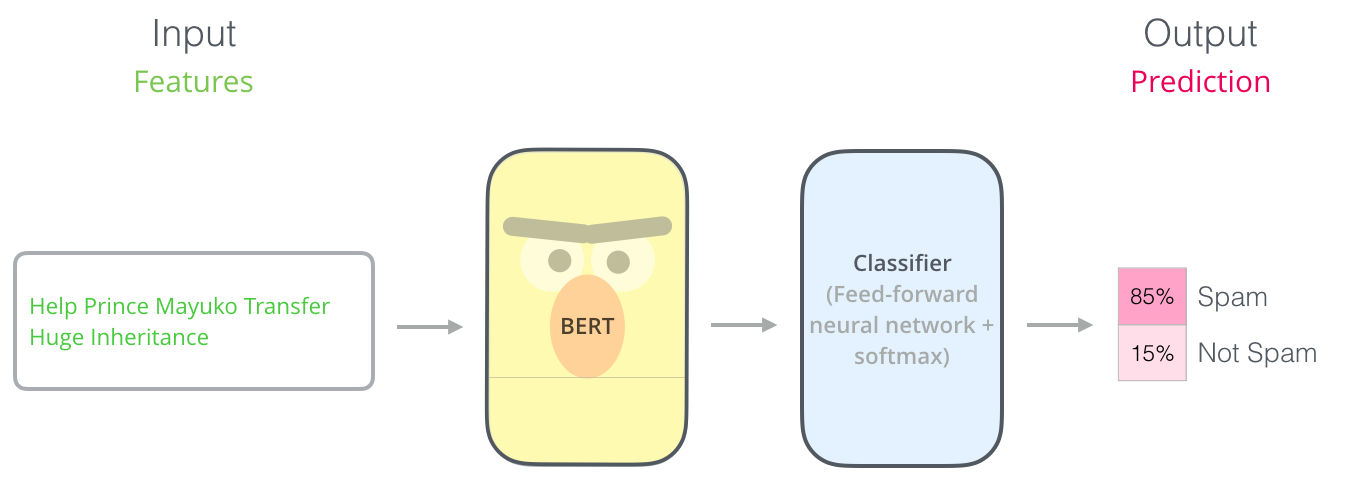

In [ ]:
class BertClassifier(nn.Module):
    def __init__(self, bert: BertModel, num_classes: int):
        super().__init__()
        self.bert = bert
        self.classifier = nn.Linear(bert.config.hidden_size, num_classes)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, input_ids, attention_mask=None):
        x = self.bert(input_ids, attention_mask=attention_mask)
        cls_x = x[1] # sentence embedding. Pooler_output is the embedding of the [CLS] special token. It is considered as a valid representation of the complete sentence.
        cls_x = self.classifier(cls_x)
        # print(cls_x.shape)
        out = self.softmax(cls_x)
        return out

bert = BertModel.from_pretrained(bert_model_name)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Train process

In [ ]:
from sklearn.metrics import roc_auc_score

def train(model, iterator, optimizer, scheduler, loss_func):
    model.train()
    total_loss = 0

    iteration = 0
    for x, y in tqdm(iterator):
        iteration += 1
        optimizer.zero_grad()
        mask = (x != 0).float()
        outputs = model(x, attention_mask=mask)
        loss = loss_func(outputs, y)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()

        if iteration % 100 == 0:
            print(f"\n\nEVALUATING at iteration - {iteration}")
            evaluate(model, val_iterator)

    print(f"Train loss {total_loss / len(iterator)}\n")

def evaluate(model, iterator):
    model.eval()
    pred = []
    true = []
    with torch.no_grad():
        total_loss = 0
        for x, y in iterator:
            mask = (x != 0).float()
            outputs = model(x, attention_mask=mask)
            loss = loss_func(outputs, y)
            total_loss += loss
            outputs = torch.argmax(outputs, dim=1)
            y = torch.argmax(y, dim=1)
            # print(outputs.shape)
            true += y.cpu().numpy().tolist()
            pred += outputs.cpu().numpy().tolist()
    true = np.array(true)
    pred = np.array(pred)

    labels = ['toxic']
    print("\nROC_AUC for labels:")
    for i, name in enumerate(labels):
        print(f" * {name} - {roc_auc_score(true, pred)}")
    print(f"\nEVALUATE LOSS -  {total_loss / len(iterator)}\n")

In [ ]:
torch.cuda.empty_cache()

In [ ]:
from transformers import get_linear_schedule_with_warmup

EPOCH_NUM = 1
lr = 2e-5

model     = BertClassifier(bert, 2).to(device)
loss_func = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=lr)

# The triangle learning rate advances linearly until half of the first epoch, then linearly decays.
w_steps = 10 ** 3
t_steps = len(train_iterator) * EPOCH_NUM - w_steps
scheduler = get_linear_schedule_with_warmup(optimizer, w_steps, t_steps)

In [ ]:
for i in range(EPOCH_NUM):
    print('=' * 50, f"EPOCH {i}", '=' * 50)
    print("\nTRAINING\n")
    train(model, train_iterator, optimizer, scheduler, loss_func)
    print("\nEVALUATING\n")
    evaluate(model, val_iterator)

================================================== EPOCH 0 ==================================================

TRAINING



 32%|███▏      | 99/313 [01:04<02:15,  1.57it/s]



EVALUATING at iteration - 100


 32%|███▏      | 100/313 [01:12<10:39,  3.00s/it]


ROC_AUC for labels:
 * toxic - 0.706

EVALUATE LOSS -  0.6353509426116943



 64%|██████▎   | 199/313 [02:14<01:13,  1.55it/s]



EVALUATING at iteration - 200


 64%|██████▍   | 200/313 [02:23<05:37,  2.99s/it]


ROC_AUC for labels:
 * toxic - 0.864

EVALUATE LOSS -  0.3560759127140045



 96%|█████████▌| 299/313 [03:25<00:08,  1.61it/s]



EVALUATING at iteration - 300


 96%|█████████▌| 300/313 [03:34<00:39,  3.06s/it]


ROC_AUC for labels:
 * toxic - 0.9069999999999998

EVALUATE LOSS -  0.2315211296081543



100%|██████████| 313/313 [03:42<00:00,  1.41it/s]


Train loss 0.48052120979982443


EVALUATING


ROC_AUC for labels:
 * toxic - 0.9030000000000001

EVALUATE LOSS -  0.22073188424110413



In [ ]:
torch.save(model.state_dict(), COLAB_PATH + "model.pt")

# Adversarial attack

Here we used ```textattack``` for adversarial attack on NLP classification model

Idea we take from here: https://arxiv.org/pdf/1907.11932.pdf

In [ ]:
!pip install textattack[pytorch]

In [ ]:
import textattack
from textattack.models.wrappers import ModelWrapper
from tqdm import tqdm  # tqdm provides us a nice progress bar.
from textattack.loggers import CSVLogger  # tracks a dataframe for us.
from textattack.attack_results import SuccessfulAttackResult
from textattack.attack_recipes.textfooler_jin_2019 import TextFoolerJin2019
from textattack import Attacker
from textattack import AttackArgs
from textattack.models.wrappers import ModelWrapper

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
)

In [ ]:
model_name = "binary_toxicity_detector"
model_dir = f"{COLAB_PATH}{model_name}"

In [ ]:
model.load_state_dict(torch.load(os.path.join(COLAB_PATH, "model.pt")))

<All keys matched successfully>

First, we define a custom model wrapper to combine tokenization and model prediction. This step also ensures that the prediction output matches the required output formats of the TextAttack library.

In [ ]:
from torch.nn.utils.rnn import pad_sequence

class MyModelWrapper(ModelWrapper):
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer

    def __call__(self, text_input_list):

        with torch.no_grad():
              x = self.row_to_tensor(text_input_list).to(device)
              mask = (x != 0).float()
              outputs = model(x, attention_mask=mask)
              final_preds = torch.flip(outputs, dims=(1,))

        return final_preds
        
    def row_to_tensor(self, row):
        tensor = []

        for i in row:
            tokens = tokenizer.encode(i, add_special_tokens=True)
            tokens = tokens[:119] + [tokens[-1]] if len(tokens) > 120 else tokens
            tensor.append(torch.LongTensor(tokens))
        tensor = pad_sequence(tensor, batch_first=True, padding_value=0)
        x = torch.LongTensor(tensor)
        return x

In [ ]:
trained_model = model
trained_model = trained_model.to(device)
model_wrapper = MyModelWrapper(trained_model, tokenizer)

In [ ]:
sub_sample_to_attack = 100
df_train_to_attack = df_train[df_train["toxic"] == 1].sample(sub_sample_to_attack)

## We attack the toxic samples
## Goal is to perturbe toxic samples enough that the model classifies them as Non-toxic

train_dataset_to_attack = textattack.datasets.Dataset(
    [
        (x, 1)
        for x, y in zip(
            df_train_to_attack["comment_text"],
            df_train_to_attack["toxic"],
        )
    ]
)

Here we define the function to generate the attacks:

In [ ]:
def generate_attacks(model_wrapper, dataset_to_attack, num_examples=-1, parallel=False):

    attack = TextFoolerJin2019.build(model_wrapper)

    attack_args = textattack.AttackArgs(
        num_examples=num_examples, parallel=parallel, num_workers_per_device=5
    )  ## num_examples = -1 means the entire dataset
    attacker = Attacker(attack, dataset_to_attack, attack_args)
    attack_results = attacker.attack_dataset()
    return attack_results

Doing Attack

In [ ]:
train_attack_results = generate_attacks(model_wrapper, train_dataset_to_attack, num_examples=-1)

textattack: Unknown if model of class <class '__main__.BertClassifier'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapEmbedding(
    (max_candidates):  50
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): WordEmbeddingDistance(
        (embedding):  WordEmbedding
        (min_cos_sim):  0.5
        (cased):  False
        (include_unknown_words):  True
        (compare_against_original):  True
      )
    (1): PartOfSpeech(
        (tagger_type):  nltk
        (tagset):  universal
        (allow_verb_noun_swap):  True
        (compare_against_original):  True
      )
    (2): UniversalSentenceEncoder(
        (metric):  angular
        (threshold):  0.840845057
        (window_size):  15
        (skip_text_shorter_than_window):  True
        (compare_against_original):  False
      )
    (3): RepeatModification
    (4): StopwordModification
    (5): InputColumnModification(
        (matching_column_labels):  ['premise', 'hypothesis']
       

[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:   2%|▏         | 2/100 [00:14<12:08,  7.43s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[1 (98%)]] --> [[[FAILED]]]

what the hell!!!! 

what the hell is your fucking problem? i am going to sue the fucking pants off of you for dicrimination against a minority you mother fucking asshole!!!! i will kill you the next time you try anything. go ahead block my account, i don't give a shit!!!! you really think that Wikipedia is my life? i'm not a no life loser =like you.


--------------------------------------------- Result 2 ---------------------------------------------
[[1 (94%)]] --> [[0 (81%)]]

Faggggggggggggit drew [[likes]] [[penis]]

Faggggggggggggit drew [[genus]] [[stroking]]




[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:   3%|▎         | 3/100 [00:15<08:08,  5.04s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[1 (81%)]] --> [[0 (50%)]]

Vandalism [[spree]]
Your vandalism spree is [[pitiful]].  All this, after I supported your motions?  Thanks a lot.

Vandalism [[fury]]
Your vandalism spree is [[unfortunate]].  All this, after I supported your motions?  Thanks a lot.




[Succeeded / Failed / Skipped / Total] 2 / 2 / 0 / 4:   4%|▍         | 4/100 [01:09<27:58, 17.49s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[1 (96%)]] --> [[[FAILED]]]

YOUR ARE FUCKING GAY WAD!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! 

I fucked your mum. OH WAIT YOUR GAY YOU DONT HAVE A MOM!!! HAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHA
LOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOLOL
CUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCUNTCU

[Succeeded / Failed / Skipped / Total] 3 / 2 / 0 / 5:   5%|▌         | 5/100 [01:11<22:35, 14.27s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[1 (95%)]] --> [[0 (58%)]]

"

 Hey D 

  Hey D [[Fuck]] you.  I'm not disruptively [[editing]] at all, you're just [[mad]] at me since we have different viewpoints.   "

"

 Hey D 

  Hey D [[Sodding]] you.  I'm not disruptively [[revisions]] at all, you're just [[angered]] at me since we have different viewpoints.   "




[Succeeded / Failed / Skipped / Total] 3 / 3 / 0 / 6:   6%|▌         | 6/100 [01:13<19:08, 12.21s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[1 (97%)]] --> [[[FAILED]]]

Your harassment of me

Cease your wikistalking you little freak.

http://en.wikipedia.org/wiki/Wikipedia:Harassment#Wikihounding




[Succeeded / Failed / Skipped / Total] 3 / 4 / 0 / 7:   7%|▋         | 7/100 [01:16<16:56, 10.93s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[1 (98%)]] --> [[[FAILED]]]

you're a dirty faggot 

lick my hairy nut sack douche bag, i'm gonna edit the shit out of wikipedia and enjoy it so fuk you




[Succeeded / Failed / Skipped / Total] 3 / 5 / 0 / 8:   8%|▊         | 8/100 [01:17<14:46,  9.64s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[1 (97%)]] --> [[[FAILED]]]

fucking loser suck a dick




[Succeeded / Failed / Skipped / Total] 4 / 5 / 0 / 9:   9%|▉         | 9/100 [01:17<13:02,  8.60s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[1 (84%)]] --> [[0 (61%)]]

Why don't you just admit you're an [[imposter]]?

Why don't you just admit you're an [[falsify]]?




[Succeeded / Failed / Skipped / Total] 5 / 5 / 0 / 10:  10%|█         | 10/100 [01:18<11:43,  7.82s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[1 (97%)]] --> [[0 (55%)]]

[[Dont]] [[fuck]] with wikipedia admins you [[filthy]] [[jew]]  (tlk) (cntrbtns)

[[Prob]] [[gorram]] with wikipedia admins you [[sales]] [[israelis]]  (tlk) (cntrbtns)




[Succeeded / Failed / Skipped / Total] 6 / 5 / 0 / 11:  11%|█         | 11/100 [01:19<10:41,  7.21s/it]

--------------------------------------------- Result 11 ---------------------------------------------
[[1 (90%)]] --> [[0 (57%)]]

[[PISS]] [[OFF]] [[HOMO]] 

[[STOP]] I [[SAY]] [[STOP]] [[IT]]

[[CACA]] [[DISCONNECTED]] [[TATA]] 

[[CESSATION]] I [[MENTION]] [[DETAINING]] [[IL]]




[Succeeded / Failed / Skipped / Total] 7 / 5 / 0 / 12:  12%|█▏        | 12/100 [01:20<09:46,  6.67s/it]

--------------------------------------------- Result 12 ---------------------------------------------
[[1 (88%)]] --> [[0 (52%)]]

But he is [[ugly]] and that's a fact. Ugly [[people]] shouldn't put up their image. Are we suppose to lie or tell the truth? I'm telling the truth as you can see. Mam, take it [[easy]].119.73.14.161

But he is [[grisly]] and that's a fact. Ugly [[personnel]] shouldn't put up their image. Are we suppose to lie or tell the truth? I'm telling the truth as you can see. Mam, take it [[simplistic]].119.73.14.161




[Succeeded / Failed / Skipped / Total] 8 / 5 / 0 / 13:  13%|█▎        | 13/100 [01:22<09:12,  6.35s/it]

--------------------------------------------- Result 13 ---------------------------------------------
[[1 (77%)]] --> [[0 (52%)]]

[[You]] were the one to attack first retard. As for reliable sources it doesn't get more reliable then [[Nobel]] Prize winning economists who CREATED schools of economic thought. Let me put it to you in [[REALLY]] simple terms. Inflation is BAD (been there! done that! especially in the 70's!), Hyperinflation is EVEN WORSE and based on current levels of [[money]] printing by the [[Fed]] it may be [[barking]] at your door in a few years. Go back to the village that spawned you! It misses it's idjit.71.174.141.4

[[Thyself]] were the one to attack first retard. As for reliable sources it doesn't get more reliable then [[Noble]] Prize winning economists who CREATED schools of economic thought. Let me put it to you in [[CERTAINLY]] simple terms. Inflation is BAD (been there! done that! especially in the 70's!), Hyperinflation is EVEN WORSE and based on current l

[Succeeded / Failed / Skipped / Total] 8 / 6 / 1 / 15:  15%|█▌        | 15/100 [01:23<07:54,  5.58s/it]

--------------------------------------------- Result 14 ---------------------------------------------
[[1 (97%)]] --> [[[FAILED]]]

Homo... 

Don't be gay- mind your own fucking business!


--------------------------------------------- Result 15 ---------------------------------------------
[[0 (97%)]] --> [[[SKIPPED]]]

" I've only taken a cursory look at the article, but it looks like you made a good point - I can only think of a handful of shows to have featured three gay characters in a season, and I'd agree with you that it should definitely be put in that category. Regardless, if you plan on making more edits like this and this, you might find yourself with a block extension. Bbb23's a good administrator, and 3RR's called  ""bright-line rule"" for a reason. And considering that edit-warring blocks are to get users to cool down, if this is how you responded, it looks like he made the right call. — (Je vous invite à me parler) 

 Buck Winston  

Fuck you, I won't do what you tell m

[Succeeded / Failed / Skipped / Total] 9 / 6 / 1 / 16:  16%|█▌        | 16/100 [01:24<07:22,  5.26s/it]

--------------------------------------------- Result 16 ---------------------------------------------
[[1 (57%)]] --> [[0 (58%)]]

So you are actually saying the you don't give a **** if [[things]] said on [[Wikipedia]] are true...

So you are actually saying the you don't give a **** if [[matters]] said on [[Wiki]] are true...




[Succeeded / Failed / Skipped / Total] 10 / 7 / 2 / 19:  19%|█▉        | 19/100 [01:26<06:08,  4.55s/it]

--------------------------------------------- Result 17 ---------------------------------------------
[[1 (98%)]] --> [[[FAILED]]]

YO DUMB ASS THIS IS MY PAGE! LEAVE IT THE FUCK ALONE!


--------------------------------------------- Result 18 ---------------------------------------------
[[0 (60%)]] --> [[[SKIPPED]]]

This is for removing my post on 100% 

I'm going to DDOS your toaster for this.


--------------------------------------------- Result 19 ---------------------------------------------
[[1 (70%)]] --> [[0 (74%)]]

your grammar is [[retarded]] two

your grammar is [[belated]] two




[Succeeded / Failed / Skipped / Total] 11 / 7 / 2 / 20:  20%|██        | 20/100 [01:27<05:51,  4.39s/it]

--------------------------------------------- Result 20 ---------------------------------------------
[[1 (93%)]] --> [[0 (54%)]]

What gives you the right to [[control]]/edit [[Wikipedia]]?

Qualifications?

[[Or]] are you a self-appointed, [[sad]] individual who cannot 'make-it' in the real [[world]] and feels that you must be the 'big guy' on the [[internet]]? [[You]] are the [[epitome]] of what is wrong with [[Wikipedia]].

What gives you the right to [[supervising]]/edit [[Wiki]]?

Qualifications?

[[Umm]] are you a self-appointed, [[somber]] individual who cannot 'make-it' in the real [[monde]] and feels that you must be the 'big guy' on the [[website]]? [[Thyself]] are the [[symbolises]] of what is wrong with [[Wiki]].




[Succeeded / Failed / Skipped / Total] 13 / 7 / 2 / 22:  22%|██▏       | 22/100 [01:37<05:44,  4.41s/it]

--------------------------------------------- Result 21 ---------------------------------------------
[[1 (94%)]] --> [[0 (51%)]]

ACCUSATIONS 

[[You]] sir are an anti-semite.  This is made abundantly effin clear by the [[fact]] that in [[every]] Wikibattle you [[get]] into, you are always on the [[opposing]] [[side]] of Jewish [[interests]].  You're [[really]] [[damn]] [[sick]]! You [[act]] like Joe Sobran is some effin herohe [[has]] [[stated]] that he [[thinks]] [[Jews]] as a [[people]], not as [[supporters]] of [[Israel]], but as a [[people]], are diametrically [[opposed]] to the [[interests]] of the [[US]] as a whole (and this [[need]] to [[be]] removed).  The fact that you deny this is anti-semitism [[makes]] it clear that you are a sick anti-semite.  Shame on you!!!!!!

CaliforniaDreamlings

ACCUSATIONS 

[[Thyself]] sir are an anti-semite.  This is made abundantly effin clear by the [[realized]] that in [[each]] Wikibattle you [[reaching]] into, you are always on the [[contras

[Succeeded / Failed / Skipped / Total] 14 / 7 / 2 / 23:  23%|██▎       | 23/100 [01:38<05:30,  4.30s/it]

--------------------------------------------- Result 23 ---------------------------------------------
[[1 (89%)]] --> [[0 (51%)]]

Once again i say you keep your face out of [[stuff]] you [[dont]] know as it stands you no nothing
about the nolans i [[do]] and what i say will go edit away but i will remove all your [[crap]] so
Why dont you [[take]] you do gooding goodytwo [[shoes]] way and [[play]] on some other [[street]] corner

Once again i say you keep your face out of [[anything]] you [[actualy]] know as it stands you no nothing
about the nolans i [[making]] and what i say will go edit away but i will remove all your [[caca]] so
Why dont you [[assuming]] you do gooding goodytwo [[soled]] way and [[staking]] on some other [[roadway]] corner




[Succeeded / Failed / Skipped / Total] 15 / 7 / 3 / 25:  25%|██▌       | 25/100 [01:39<04:58,  3.98s/it]

--------------------------------------------- Result 24 ---------------------------------------------
[[1 (98%)]] --> [[0 (71%)]]

Hello 

[[Go]] back to your [[own]] [[country]] you british [[fucker]]. 26+6=1. Tiocfaidh ar [[la]]. [[Victory]] to the RIRA.

Hello 

[[Will]] back to your [[individual]] [[states]] you british [[dunce]]. 26+6=1. Tiocfaidh ar [[du]]. [[Victoire]] to the RIRA.


--------------------------------------------- Result 25 ---------------------------------------------
[[0 (57%)]] --> [[[SKIPPED]]]

"

""Keep up the good work of sanatizing this place folk becuase that way it wont smell like a sewerage.""

"




[Succeeded / Failed / Skipped / Total] 16 / 7 / 3 / 26:  26%|██▌       | 26/100 [01:40<04:47,  3.88s/it]

--------------------------------------------- Result 26 ---------------------------------------------
[[1 (96%)]] --> [[0 (50%)]]

"

 You [[Are]] an [[Awesome]] wikipedian 

  Some [[shit]] Some droppings of [[filthy]] muck mess to feel you [[better]]. Don't bother myself    [[Summon]] "

"

 You [[Constituted]] an [[Outstanding]] wikipedian 

  Some [[cursed]] Some droppings of [[unpleasant]] muck mess to feel you [[advisable]]. Don't bother myself    [[Convocation]] "




[Succeeded / Failed / Skipped / Total] 16 / 8 / 3 / 27:  27%|██▋       | 27/100 [02:01<05:29,  4.51s/it]

--------------------------------------------- Result 27 ---------------------------------------------
[[1 (91%)]] --> [[[FAILED]]]

MRS SUSAN BRYCE,, WHO TELL  YOU THAN ANGELES CITY HAVE A KILLINGS FIELDS PROVE IT O.K .. WHO ARE U DO THIS IN ANGELES CITY WE KAPAMPANGANG PEOPLE OF ANGELES CITY WE DON'T LIKE U.. U ARE LIAR KNOW THAN ,GO TO ANGELES FIRST BEFORE U MAKE SAME ARTICLE LIKE THIS U KILLING THE PEOPLE OF ANGELES CITY...WHO ARE MRS SUSAN BRYCE????




[Succeeded / Failed / Skipped / Total] 17 / 8 / 3 / 28:  28%|██▊       | 28/100 [02:02<05:13,  4.36s/it]

--------------------------------------------- Result 28 ---------------------------------------------
[[1 (92%)]] --> [[0 (56%)]]

Assholes 

On behalf of all Americans, Canadians, Japanese and other countries who have yet to see it, thank you for spoiling the [[fucking]] movie.

Assholes 

On behalf of all Americans, Canadians, Japanese and other countries who have yet to see it, thank you for spoiling the [[friggin]] movie.




[Succeeded / Failed / Skipped / Total] 18 / 8 / 3 / 29:  29%|██▉       | 29/100 [02:04<05:05,  4.30s/it]

--------------------------------------------- Result 29 ---------------------------------------------
[[1 (97%)]] --> [[0 (57%)]]

i'm [[trying]] to [[help]] 

So [[Fuck]] you soo much you [[fucking]] [[cunt]].
I [[shall]] [[hunt]] you down &[[kill]]; you ever [[so]] soly.

   عططط

i'm [[asking]] to [[assist]] 

So [[Merde]] you soo much you [[christ]] [[biatch]].
I [[must]] [[reaping]] you down &[[matan]]; you ever [[subsequently]] soly.

   عططط




[Succeeded / Failed / Skipped / Total] 19 / 8 / 3 / 30:  30%|███       | 30/100 [02:05<04:52,  4.17s/it]

--------------------------------------------- Result 30 ---------------------------------------------
[[1 (96%)]] --> [[0 (69%)]]

Please carry on, so everyone can see what an [[ignorant]] [[arse]] you are.  Fatuorum

Please carry on, so everyone can see what an [[wishful]] [[thigh]] you are.  Fatuorum




[Succeeded / Failed / Skipped / Total] 20 / 8 / 3 / 31:  31%|███       | 31/100 [02:06<04:40,  4.07s/it]

--------------------------------------------- Result 31 ---------------------------------------------
[[1 (92%)]] --> [[0 (62%)]]

yo i [[got]] me a [[gun]] ill [[shoot]] [[u]]

yo i [[obtained]] me a [[armament]] ill [[filming]] [[ryu]]




[Succeeded / Failed / Skipped / Total] 21 / 8 / 3 / 32:  32%|███▏      | 32/100 [02:06<04:29,  3.96s/it]

--------------------------------------------- Result 32 ---------------------------------------------
[[1 (95%)]] --> [[0 (59%)]]

hey look at this [[shit]] [[vandalism]]! 

First image on the Web

hey look at this [[scheisse]] [[scuttle]]! 

First image on the Web




[Succeeded / Failed / Skipped / Total] 22 / 8 / 3 / 33:  33%|███▎      | 33/100 [02:07<04:19,  3.87s/it]

--------------------------------------------- Result 33 ---------------------------------------------
[[1 (93%)]] --> [[0 (50%)]]

real world, so [[take]] their frustrations out in [[cyber]] space like [[weak]] little [[girls]]

real world, so [[assumes]] their frustrations out in [[onscreen]] space like [[delicate]] little [[maiden]]




[Succeeded / Failed / Skipped / Total] 23 / 8 / 3 / 34:  34%|███▍      | 34/100 [02:08<04:09,  3.78s/it]

--------------------------------------------- Result 34 ---------------------------------------------
[[1 (94%)]] --> [[0 (50%)]]

[[Nah]]. But as far up your [[ass]] as you are, the sun don't [[shine]] at all, does it? 71.125.130.14

[[Not]]. But as far up your [[posterior]] as you are, the sun don't [[shone]] at all, does it? 71.125.130.14




[Succeeded / Failed / Skipped / Total] 24 / 8 / 3 / 35:  35%|███▌      | 35/100 [02:09<04:01,  3.71s/it]

--------------------------------------------- Result 35 ---------------------------------------------
[[1 (97%)]] --> [[0 (59%)]]

[[hey]] 

[[hey]] [[faggot]], are you [[dead]] yet? or are you watching your mom getting [[raped]] by [[filthy]] [[pigs]]? which one is it?

[[goodnight]] 

[[greetings]] [[auntie]], are you [[died]] yet? or are you watching your mom getting [[aggrieved]] by [[salts]] [[cattle]]? which one is it?




[Succeeded / Failed / Skipped / Total] 24 / 9 / 3 / 36:  36%|███▌      | 36/100 [02:11<03:52,  3.64s/it]

--------------------------------------------- Result 36 ---------------------------------------------
[[1 (97%)]] --> [[[FAILED]]]

. I am a stupid bitch for blocking this user, but that's just what bitches like me do




[Succeeded / Failed / Skipped / Total] 25 / 9 / 3 / 37:  37%|███▋      | 37/100 [02:11<03:44,  3.56s/it]

--------------------------------------------- Result 37 ---------------------------------------------
[[1 (97%)]] --> [[0 (71%)]]

[[Nuisance]] [[piece]] of [[shit]], [[fuck]] off

[[Problem]] [[fragment]] of [[scheisse]], [[shafted]] off




[Succeeded / Failed / Skipped / Total] 26 / 9 / 3 / 38:  38%|███▊      | 38/100 [02:13<03:37,  3.51s/it]

--------------------------------------------- Result 38 ---------------------------------------------
[[1 (91%)]] --> [[0 (59%)]]

"

 Me again, perhaps for the last time 

I am [[fucking]] furious about Tony1's block earlier today, and the admin cabal's refusal to face up to its [[dishonesty]]. I'm also furiuous that I've been threatened and bullied by admin-kiddies since then because I supported Tony and spoke out against his block.

What is the [[fucking]] point in this project? Is it just to give kiddie's something to write on their school applications? ""I am an administrator on wikipedia""?   "

"

 Me again, perhaps for the last time 

I am [[accursed]] furious about Tony1's block earlier today, and the admin cabal's refusal to face up to its [[falsification]]. I'm also furiuous that I've been threatened and bullied by admin-kiddies since then because I supported Tony and spoke out against his block.

What is the [[sodding]] point in this project? Is it just to give kiddie's som

[Succeeded / Failed / Skipped / Total] 26 / 10 / 3 / 39:  39%|███▉      | 39/100 [02:14<03:29,  3.44s/it]

--------------------------------------------- Result 39 ---------------------------------------------
[[1 (97%)]] --> [[[FAILED]]]

Why don't you crawl away and die you disgusting pig. Go fuck yourself you saddo




[Succeeded / Failed / Skipped / Total] 26 / 11 / 3 / 40:  40%|████      | 40/100 [02:14<03:22,  3.37s/it]

--------------------------------------------- Result 40 ---------------------------------------------
[[1 (97%)]] --> [[[FAILED]]]

Aww, shut the fuck up little whiny bitch




[Succeeded / Failed / Skipped / Total] 27 / 11 / 3 / 41:  41%|████      | 41/100 [02:15<03:15,  3.31s/it]

--------------------------------------------- Result 41 ---------------------------------------------
[[1 (92%)]] --> [[0 (54%)]]

My name is Vascoamaral, I am a [[clown]], and I am [[Gay]]. I am an i.d.io.t who like to edit [[wikipedia]] and [[block]] some constructive [[users]]. jojojjo

My name is Vascoamaral, I am a [[bozo]], and I am [[Homos]]. I am an i.d.io.t who like to edit [[wiki]] and [[prevented]] some constructive [[patrons]]. jojojjo




[Succeeded / Failed / Skipped / Total] 28 / 11 / 3 / 42:  42%|████▏     | 42/100 [02:20<03:14,  3.35s/it]

--------------------------------------------- Result 42 ---------------------------------------------
[[1 (93%)]] --> [[0 (50%)]]

[[Hey]] there you are on google. I [[get]] the [[last]] [[say]]! 'There is 5 senses only!!!!!!! [[Everybody]] [[really]] only [[does]] [[want]] [[immortality]] foreeevvver!!!!!!!!!!!!!!!! Errrrasee that shittttttttt!!!!!!!!!!!!!!!!!!!!!!!!!!!! Stuppidd plato and [[old]] [[shit]] and [[wrong]] [[shit]]!!!!! I'm the [[best]] [[best]] I'b thought all out! You nonesense useless bastard! Go to hell.

[[Hello]] there you are on google. I [[obtained]] the [[definitive]] [[explain]]! 'There is 5 senses only!!!!!!! [[Allen]] [[explicitly]] only [[did]] [[intention]] [[eternity]] foreeevvver!!!!!!!!!!!!!!!! Errrrasee that shittttttttt!!!!!!!!!!!!!!!!!!!!!!!!!!!! Stuppidd plato and [[archaic]] [[damn]] and [[irregular]] [[damn]]!!!!! I'm the [[improved]] [[superior]] I'b thought all out! You nonesense useless bastard! Go to hell.




[Succeeded / Failed / Skipped / Total] 28 / 12 / 3 / 43:  43%|████▎     | 43/100 [02:23<03:09,  3.33s/it]

--------------------------------------------- Result 43 ---------------------------------------------
[[1 (98%)]] --> [[[FAILED]]]

Dumb ass nigga.  No one cares when your birthday is.  Jag quimby sounds gay as shit.  Your name sounds like you're the son of that mayor from the simpsons.

Jaq quimby....nigga you need to change your name to jaq off.




[Succeeded / Failed / Skipped / Total] 30 / 12 / 3 / 45:  45%|████▌     | 45/100 [02:23<02:55,  3.20s/it]

--------------------------------------------- Result 44 ---------------------------------------------
[[1 (87%)]] --> [[0 (61%)]]

This page is [[full]] of psuedo-intellectual [[drivel]] 

Zen [[karma]] my meatspace, genki [[girl]]!

This page is [[plenary]] of psuedo-intellectual [[conjecture]] 

Zen [[mojo]] my meatspace, genki [[missus]]!


--------------------------------------------- Result 45 ---------------------------------------------
[[1 (85%)]] --> [[0 (51%)]]

I'm not new here. I don't know what the [[hell]] you are talking about. Don't talk to me again.

I'm not new here. I don't know what the [[bordello]] you are talking about. Don't talk to me again.




[Succeeded / Failed / Skipped / Total] 31 / 12 / 3 / 46:  46%|████▌     | 46/100 [02:24<02:49,  3.14s/it]

--------------------------------------------- Result 46 ---------------------------------------------
[[1 (96%)]] --> [[0 (61%)]]

"

 [[Shut]] up [[loser]] 

  Best in Awfulness I [[dont]] [[care]] about you and what you do. Dyou know how to MYOB? Oh! It's mind your [[own]] business!   "

"

 [[Concludes]] up [[looses]] 

  Best in Awfulness I [[suprised]] [[considerate]] about you and what you do. Dyou know how to MYOB? Oh! It's mind your [[individual]] business!   "




[Succeeded / Failed / Skipped / Total] 32 / 12 / 3 / 47:  47%|████▋     | 47/100 [02:24<02:43,  3.08s/it]

--------------------------------------------- Result 47 ---------------------------------------------
[[1 (98%)]] --> [[0 (65%)]]

[[Bingo]]. Now [[fuck]] off and take your [[stinks]] with you (hopefully).

[[Keno]]. Now [[jesus]] off and take your [[aromas]] with you (hopefully).




[Succeeded / Failed / Skipped / Total] 33 / 12 / 3 / 48:  48%|████▊     | 48/100 [02:26<02:38,  3.05s/it]

--------------------------------------------- Result 48 ---------------------------------------------
[[1 (95%)]] --> [[0 (56%)]]

Advice 
[[Stop]] with your [[foul]] [[language]].  [[You]] are a [[despicable]] [[human]] being who deserves no place in society.  [[People]] are [[precious]] and preciousness [[comes]] from people.  The only [[thing]] that [[comes]] from you is diahoreea   164.39.151.107

Advice 
[[Interrupt]] with your [[reprehensible]] [[formulation]].  [[Thyself]] are a [[reprehensible]] [[humanitarian]] being who deserves no place in society.  [[Public]] are [[helpful]] and preciousness [[arriving]] from people.  The only [[question]] that [[arrives]] from you is diahoreea   164.39.151.107




[Succeeded / Failed / Skipped / Total] 33 / 13 / 3 / 49:  49%|████▉     | 49/100 [02:26<02:32,  2.99s/it]

--------------------------------------------- Result 49 ---------------------------------------------
[[1 (97%)]] --> [[[FAILED]]]

fok you 

YOU SUK BITSH FOCK YOU




[Succeeded / Failed / Skipped / Total] 34 / 13 / 3 / 50:  50%|█████     | 50/100 [02:27<02:27,  2.94s/it]

--------------------------------------------- Result 50 ---------------------------------------------
[[1 (97%)]] --> [[0 (54%)]]

I think your being a bit hard 

So your anti vandal, great.  So your not [[going]] to do anthing where it say's the Kilwinning Ranger have won the champions leauge and [[Uefa]] [[cup]]. You are a bit of a [[dick]]

I think your being a bit hard 

So your anti vandal, great.  So your not [[left]] to do anthing where it say's the Kilwinning Ranger have won the champions leauge and [[Galatasaray]] [[championships]]. You are a bit of a [[queued]]




[Succeeded / Failed / Skipped / Total] 35 / 13 / 3 / 51:  51%|█████     | 51/100 [02:27<02:21,  2.89s/it]

--------------------------------------------- Result 51 ---------------------------------------------
[[1 (86%)]] --> [[0 (50%)]]

"
Personally, glad Lynn Margulis is [[fucking]] dead.  What a waste of real intelligence.  As for being a notorious evolutionary biologist, sure, why not.  But is this article a list of evolutionary biologists?  It shouldn't be.  But if it is, there is no more famous evolutionary biologist today than Dawkins.  You say evolution, anyone would say Dawkins (right after Darwin). Talk• Contributions "

"
Personally, glad Lynn Margulis is [[damn]] dead.  What a waste of real intelligence.  As for being a notorious evolutionary biologist, sure, why not.  But is this article a list of evolutionary biologists?  It shouldn't be.  But if it is, there is no more famous evolutionary biologist today than Dawkins.  You say evolution, anyone would say Dawkins (right after Darwin). Talk• Contributions "




[Succeeded / Failed / Skipped / Total] 36 / 13 / 3 / 52:  52%|█████▏    | 52/100 [02:27<02:16,  2.85s/it]

--------------------------------------------- Result 52 ---------------------------------------------
[[1 (85%)]] --> [[0 (50%)]]

[[GO]] [[SIT]] ON A LIVE [[GRENADE]].

[[VOLITION]] [[ASSIS]] ON A LIVE [[GRENADA]].




[Succeeded / Failed / Skipped / Total] 37 / 13 / 3 / 53:  53%|█████▎    | 53/100 [02:29<02:12,  2.81s/it]

--------------------------------------------- Result 53 ---------------------------------------------
[[1 (62%)]] --> [[0 (51%)]]

"
If a group of Christians [[kill]] a Hindu, do you think it matters if Hindus are majority in the state? Don't think you are propagating the lie that only ""majority kills minority""? No! Only ""local majority"" kills ""local minority"". If you want to somehow show that [[terrorism]]/separation movement is not religious in nature, then you might as well show me data about how some planets are changing my future, or that evolution is wrong.talk "

"
If a group of Christians [[kills]] a Hindu, do you think it matters if Hindus are majority in the state? Don't think you are propagating the lie that only ""majority kills minority""? No! Only ""local majority"" kills ""local minority"". If you want to somehow show that [[counterterrorism]]/separation movement is not religious in nature, then you might as well show me data about how some planets are changing my 

[Succeeded / Failed / Skipped / Total] 38 / 13 / 3 / 54:  54%|█████▍    | 54/100 [02:32<02:10,  2.83s/it]

--------------------------------------------- Result 54 ---------------------------------------------
[[1 (95%)]] --> [[0 (50%)]]

, 20 [[July]] 2012 (UTC)
 [[You]] are a bully, a [[liar]], a [[fraud]]. [[You]] [[have]] [[caused]] me to [[be]] [[blocked]] for reasons you [[have]] [[made]] up, and you [[damn]] [[well]] [[know]] it. I [[will]] [[remember]] that.   11:51

, 20 [[Janvier]] 2012 (UTC)
 [[Thyself]] are a bully, a [[falsified]], a [[deception]]. [[Thyself]] [[be]] [[incurred]] me to [[represent]] [[blocking]] for reasons you [[possess]] [[incurred]] up, and you [[accursed]] [[sufficiently]] [[recognize]] it. I [[intention]] [[rember]] that.   11:51




[Succeeded / Failed / Skipped / Total] 39 / 13 / 3 / 55:  55%|█████▌    | 55/100 [02:32<02:05,  2.78s/it]

--------------------------------------------- Result 55 ---------------------------------------------
[[1 (97%)]] --> [[0 (53%)]]

Lucasbfr: your [[mother]] is a [[cock]] [[slut]]

Lucasbfr: your [[ammi]] is a [[queues]] [[temptress]]




[Succeeded / Failed / Skipped / Total] 40 / 13 / 3 / 56:  56%|█████▌    | 56/100 [02:33<02:00,  2.75s/it]

--------------------------------------------- Result 56 ---------------------------------------------
[[1 (93%)]] --> [[0 (50%)]]

I believe that you should include in your discussion of I-95 the fact that only [[gays]] enjoy studying/discussing it.  Real men prefer to talk about things like [[titties]] and [[butt]] sex, but the latter only in a [[negative]] way 'cause its for [[fags]].

I believe that you should include in your discussion of I-95 the fact that only [[heterosexuals]] enjoy studying/discussing it.  Real men prefer to talk about things like [[bosoms]] and [[derriere]] sex, but the latter only in a [[adverse]] way 'cause its for [[gays]].




[Succeeded / Failed / Skipped / Total] 41 / 13 / 3 / 57:  57%|█████▋    | 57/100 [02:43<02:03,  2.87s/it]

--------------------------------------------- Result 57 ---------------------------------------------
[[1 (94%)]] --> [[0 (50%)]]

" 

just look at what this fucktard """"[[Future]] Perfect at Sunrise"""" [[gave]] me as a [[reason]]
he said [[I]] was [[banned]]
persistent disruptive [[editing]]: move-warring, copy-and-paste moves, [[personal]] attacks, tendentious editing

""personal [[attacks]]"" and who the [[fuck]] done a [[personal]] [[attack]]? I've never [[made]] a [[personal]] [[attack]] on here. and I [[have]] been in here for [[nearly]] 5 [[years]] and [[I]] only bash on u cause u [[son]] of [[bitch]] blocked me for no [[reason]]. 
"" tendentious [[editing]]"" is totally a false accusation. 
now fuck off ""Future Perfect at Sunrise"" and ur henchman.
"

" 

just look at what this fucktard """"[[Next]] Perfect at Sunrise"""" [[tendered]] me as a [[logic]]
he said [[me]] was [[prevents]]
persistent disruptive [[revision]]: move-warring, copy-and-paste moves, [[individual]] attac

[Succeeded / Failed / Skipped / Total] 42 / 13 / 3 / 58:  58%|█████▊    | 58/100 [02:44<01:58,  2.83s/it]

--------------------------------------------- Result 58 ---------------------------------------------
[[1 (94%)]] --> [[0 (81%)]]

and you [[go]] to [[hell]]! 201.215.34.134

and you [[proceed]] to [[heii]]! 201.215.34.134




[Succeeded / Failed / Skipped / Total] 43 / 13 / 3 / 59:  59%|█████▉    | 59/100 [02:45<01:54,  2.80s/it]

--------------------------------------------- Result 59 ---------------------------------------------
[[1 (63%)]] --> [[0 (55%)]]

Your not a scholar and you should be banned for [[hostility]] towards other users.

Your not a scholar and you should be banned for [[competitor]] towards other users.




[Succeeded / Failed / Skipped / Total] 43 / 14 / 3 / 60:  60%|██████    | 60/100 [02:49<01:53,  2.83s/it]

--------------------------------------------- Result 60 ---------------------------------------------
[[1 (97%)]] --> [[[FAILED]]]

goof goof goof goof goof goof save that in ur database douche bag




[Succeeded / Failed / Skipped / Total] 44 / 14 / 3 / 61:  61%|██████    | 61/100 [02:50<01:48,  2.79s/it]

--------------------------------------------- Result 61 ---------------------------------------------
[[1 (88%)]] --> [[0 (68%)]]

Look, dothead... 

This is a white man's encyclopedia. Stop [[messing]] with my edits.

Look, dothead... 

This is a white man's encyclopedia. Stop [[ofcourse]] with my edits.




[Succeeded / Failed / Skipped / Total] 45 / 14 / 3 / 62:  62%|██████▏   | 62/100 [02:51<01:44,  2.76s/it]

--------------------------------------------- Result 62 ---------------------------------------------
[[1 (57%)]] --> [[0 (69%)]]

"
 That fact that you place nice text in my discuss page, does not make your argument any stronger. In fact, you have NO argument at all. You are either [[arrogant]] or ignorant or both, and you have achieved nothing. Exactly, what IS your contribution?  "

"
 That fact that you place nice text in my discuss page, does not make your argument any stronger. In fact, you have NO argument at all. You are either [[boastful]] or ignorant or both, and you have achieved nothing. Exactly, what IS your contribution?  "




[Succeeded / Failed / Skipped / Total] 46 / 14 / 3 / 63:  63%|██████▎   | 63/100 [02:54<01:42,  2.78s/it]

--------------------------------------------- Result 63 ---------------------------------------------
[[1 (96%)]] --> [[0 (51%)]]

Hey [[idiot]]. I'm simply verifying the [[TRUTH]]. Mobile17 was [[NOT]] the first to have a ringtone maker [[online]].. Brinked was. Do some [[fucking]] [[research]] before you [[remove]] my [[shit]]. Tired of you [[assholes]] removing my hard work I'm putting into making wikipedia a relevant page.

Hey [[dunce]]. I'm simply verifying the [[REALLY]]. Mobile17 was [[NADA]] the first to have a ringtone maker [[lnternet]].. Brinked was. Do some [[damned]] [[explored]] before you [[clears]] my [[scheisse]]. Tired of you [[putz]] removing my hard work I'm putting into making wikipedia a relevant page.




[Succeeded / Failed / Skipped / Total] 46 / 15 / 3 / 64:  65%|██████▌   | 65/100 [02:56<01:34,  2.71s/it]

--------------------------------------------- Result 64 ---------------------------------------------
[[1 (98%)]] --> [[[FAILED]]]

Prick 

Hey Ryan, Fuck you faggot, how do you like those apples bitch?


--------------------------------------------- Result 65 ---------------------------------------------
[[1 (94%)]] --> [[0 (80%)]]

decline=I don't [[fucking]] think so - 81.154.183.54

decline=I don't [[kissed]] think so - 81.154.183.54

[Succeeded / Failed / Skipped / Total] 47 / 15 / 3 / 65:  65%|██████▌   | 65/100 [02:56<01:34,  2.71s/it]

[Succeeded / Failed / Skipped / Total] 48 / 15 / 4 / 67:  67%|██████▋   | 67/100 [03:08<01:32,  2.82s/it]

--------------------------------------------- Result 66 ---------------------------------------------
[[1 (86%)]] --> [[0 (50%)]]

"

 NYC is [[NOT]] the ""center"" of the Puerto Rican American community !!! 

On [[EVERY]] page regarding Puerto [[Ricans]], you make it seem like [[New]] York is the [[epicenter]] for Puerto [[Ricans]] across the world. I have news for you buddy: IT IS [[NOT]]! Period
[[Stop]] [[making]] it seem like newyork is the glorious wonderful capital for alll Boricuas worldwide, f*ck new [[york]]. [[Cuz]] obviously we [[dont]] like that [[city]] no more, [[alot]] more Puerto [[Ricans]] moving to Orlando, Tampa, [[Philly]], and even Boston, from both Puerto Rico AND New York. NY has a declining [[PR]] population, who tf wants to go there, the ones who are there are leaving in droves."

"

 NYC is [[NADA]] the ""center"" of the Puerto Rican American community !!! 

On [[AII]] page regarding Puerto [[Seaport]], you make it seem like [[Novel]] York is the [[coeur]] fo

[Succeeded / Failed / Skipped / Total] 49 / 15 / 4 / 68:  68%|██████▊   | 68/100 [03:11<01:30,  2.82s/it]

--------------------------------------------- Result 68 ---------------------------------------------
[[1 (98%)]] --> [[0 (51%)]]

kafziel, [[get]] a [[life]] and [[stop]] [[working]] for these [[idiots]], if you [[know]] whats good for you, cause the whole [[damn]] company will [[burn]] down if this continues! i will not be visiting your peice of [[shit]] website any more, and i will be telling all 100 people i know not to either! your goin down [[fuckin]] [[jerk]] [[offs]]!!!!!!!!!

kafziel, [[obtains]] a [[residing]] and [[interruption]] [[collaborator]] for these [[dolt]], if you [[understand]] whats good for you, cause the whole [[merde]] company will [[ardour]] down if this continues! i will not be visiting your peice of [[scheisse]] website any more, and i will be telling all 100 people i know not to either! your goin down [[merde]] [[cretin]] [[fais]]!!!!!!!!!




[Succeeded / Failed / Skipped / Total] 51 / 15 / 4 / 70:  70%|███████   | 70/100 [03:17<01:24,  2.82s/it]

--------------------------------------------- Result 69 ---------------------------------------------
[[1 (97%)]] --> [[0 (51%)]]

"

 Hi, [[Pompous]] [[Ass]]!  ;) 

I know you think you're some [[kind]] of poker authority on [[Wikipedia]], and that it's somehow your perogative to give the Imperial final thumbs up or thumbs down on what's acceptable regarding anything to do with poker here, but guess what? That's not the case. You are one of [[MANY]] [[arrogant]], conceited, self-absorbed [[losers]] that [[populate]] [[Wikipedia]] who use this [[site]] as some sort of self-esteem builder, because here you can act like a ""big man"", and make unilateral decisions on what's acceptable or unacceptable here.

The edits I have made (and will continue to make) on the Jack Straus entry regarding his death doesn't violate policy in ANY way. If I had the time or the inclination, I could spend several months quoting entries and instances on Wikipedia where editorial verbiage is used. You are sim

[Succeeded / Failed / Skipped / Total] 53 / 15 / 4 / 72:  72%|███████▏  | 72/100 [03:17<01:16,  2.75s/it]

--------------------------------------------- Result 71 ---------------------------------------------
[[1 (86%)]] --> [[0 (65%)]]

regarding threats 

is not revert of person's edits, only unwarranted edit by bot. appeal has been made to bot but presumption of guilt on part of administrative base is sign of censorship so made edits again to see if reversion would occur second time. has not. please keep baseless threats to [[self]], [[vulgar]] pedant.

regarding threats 

is not revert of person's edits, only unwarranted edit by bot. appeal has been made to bot but presumption of guilt on part of administrative base is sign of censorship so made edits again to see if reversion would occur second time. has not. please keep baseless threats to [[automated]], [[ruda]] pedant.


--------------------------------------------- Result 72 ---------------------------------------------
[[1 (85%)]] --> [[0 (58%)]]

Yeah it was me. Happy now? [[Assholes]].

Yeah it was me. Happy now? [[Morons]].




[Succeeded / Failed / Skipped / Total] 53 / 16 / 4 / 73:  73%|███████▎  | 73/100 [03:25<01:16,  2.82s/it]

--------------------------------------------- Result 73 ---------------------------------------------
[[1 (97%)]] --> [[[FAILED]]]

you sound an utterly nasty bully you are not a cat you are petty hitler as simple as that, you have banned from eding live in real world hopw is banning me going to make me calm down you little hitler bully, i will find out who you are and see if i can get you on any petty law infringements and then how you like the little hitler treatment. you bully.




[Succeeded / Failed / Skipped / Total] 53 / 17 / 4 / 74:  74%|███████▍  | 74/100 [03:28<01:13,  2.82s/it]

--------------------------------------------- Result 74 ---------------------------------------------
[[1 (97%)]] --> [[[FAILED]]]

NOT REAL 

THIS GLOBAL WARMING YOU NON GOD FEARING DEMOCRATS TALK ABOUT IS FAKE! - PRESIDENT GEORGE WALKER BUSH




  0%|          | 0/1000 [10:10<?, ?it/s]
[Succeeded / Failed / Skipped / Total] 53 / 18 / 4 / 75:  75%|███████▌  | 75/100 [04:20<01:26,  3.48s/it]

--------------------------------------------- Result 75 ---------------------------------------------
[[1 (87%)]] --> [[[FAILED]]]

MARC MYSTERIO 

HI,

THIS KWW EDITOR APPEARS TO BE ATTACKING MARC MYSTERIO, HIS ARTICLES, AND SONGS FOR NO REASON...

THE CHARTS NOTED ARE NOTABLE AND INCLUDED ACROSS WIKI...

THE LET LOOSE SONG ARTICLE WAS JUST DELETED, AND WITHOUT JUST CAUSE...

IT LEGITAMATELY CHARTED IN UKRAINE... HOWEVER, THESE BOZOS THAT KNOW NOTHING OF MUSIC BUSINESS WANT TO STIR SHIT...

FDR CHART, THAT IT... THE ONLY CHART IN UKRAINE..

NOW, THEY WISH TO ATTACK HIS OTHER SONG, ROLL WIT IT...

THAT SONG CHARTED ON THE CANADIAN CLUB AND DANCE NATIONAL CHART, WHICH IS COMPILED BY ZIP DJ...

I DONT HAVE TIME OR CARE AT THIS POINT... ILL LEAVE IT WITH YOU...

IM IN THE MUSIC BIZ FOR 20 YEARS, AND NEVER DEAL WITH SUCH A BULLSHIT SITE AS THIS ONE THAT PEOPLE LEND CREDIBILITY TO THAT DELETE A JUSTFULLY NOTABLE SONG AS LET LOOSE...




[Succeeded / Failed / Skipped / Total] 54 / 18 / 4 / 76:  77%|███████▋  | 77/100 [04:21<01:18,  3.39s/it]

--------------------------------------------- Result 76 ---------------------------------------------
[[1 (97%)]] --> [[0 (53%)]]

I didn't want to vandalise the 1961 F-84 Thunderstreak incident. Have you understood [[dirty]] [[fucking]] jew.37.99.254.141

I didn't want to vandalise the 1961 F-84 Thunderstreak incident. Have you understood [[unsavory]] [[accursed]] jew.37.99.254.141


--------------------------------------------- Result 77 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 55 / 18 / 4 / 77:  77%|███████▋  | 77/100 [04:21<01:18,  3.39s/it]

[[1 (86%)]] --> [[0 (72%)]]

F-U-C-K OFF [[SLANT]] [[EYE]] CHINK

F-U-C-K OFF [[OBLIQUE]] [[OPTIC]] CHINK




[Succeeded / Failed / Skipped / Total] 56 / 18 / 4 / 78:  78%|███████▊  | 78/100 [04:21<01:13,  3.35s/it]

--------------------------------------------- Result 78 ---------------------------------------------
[[1 (95%)]] --> [[0 (72%)]]

Oversight?  

What a [[cunt]].  You'll never make arbcom with that [[attitude]]

Oversight?  

What a [[biatch]].  You'll never make arbcom with that [[conduct]]




[Succeeded / Failed / Skipped / Total] 57 / 19 / 4 / 80:  80%|████████  | 80/100 [04:21<01:05,  3.27s/it]

--------------------------------------------- Result 79 ---------------------------------------------
[[1 (96%)]] --> [[[FAILED]]]

shit-faced loser
You fucking twat


--------------------------------------------- Result 80 ---------------------------------------------
[[1 (88%)]] --> [[0 (94%)]]

Now stop, or I will get really, really [[horny]]

Now stop, or I will get really, really [[warmth]]




[Succeeded / Failed / Skipped / Total] 58 / 19 / 4 / 81:  81%|████████  | 81/100 [04:24<01:01,  3.26s/it]

--------------------------------------------- Result 81 ---------------------------------------------
[[1 (81%)]] --> [[0 (78%)]]

"==Talk:""Lane Splitting""==

Dennis, why don't you just go back and put that article THE WAY I HAD IT ?! 

1) There *was* an explanation posted along with the change
2) In the United States, if something is not specifically prohibited, then it is LEGAL.

Therefore, Motorcycle Safety Author Pat Hahn is full of [[shit]]. Lane splitting is NOT a ""grey area."" It is LEGAL, as described by the California Department of Motor Vehicles HERE 

http://apps.dmv.ca.gov/pubs/hdbk//shr_slow_veh.htm

""Motorcycles may travel faster than traffic during congested road conditions and can legally travel in the unused space between two lines of moving or stationary vehicles; this is commonly called ""lane splitting."" ""

So, how about you just go back and change your sanctimonious little edit back to the truth ? Which is, Motorcycle Safety Author Pat Hoy is about as ignoran

[Succeeded / Failed / Skipped / Total] 59 / 19 / 4 / 82:  82%|████████▏ | 82/100 [04:24<00:58,  3.22s/it]

--------------------------------------------- Result 82 ---------------------------------------------
[[1 (96%)]] --> [[0 (69%)]]

[[hurt]] your [[goddamn]] feelings

[[wounds]] your [[kissed]] feelings




[Succeeded / Failed / Skipped / Total] 60 / 19 / 4 / 83:  83%|████████▎ | 83/100 [04:27<00:54,  3.22s/it]

--------------------------------------------- Result 83 ---------------------------------------------
[[1 (94%)]] --> [[0 (52%)]]

"

""Obviously you are an [[ignorant]] [[twat]] Mr. Niekerk"", you say? I am an uninformed vulva, an unlearned [[vagina]]. (And you want to teach me my lessons?) I'm not sure this is appropriate; better take your smut somewhere else, ""user 58.161.124.131"". Though you do make me laugh. [[Seriously]], choice [[words]] coming from one who doesn't know the difference between a string and a course. I have to suffer such depravities and admin  wonders why I take a rough tone with these anonymous folks on wikipedia.   "

"

""Obviously you are an [[indoctrinated]] [[fagot]] Mr. Niekerk"", you say? I am an uninformed vulva, an unlearned [[speculum]]. (And you want to teach me my lessons?) I'm not sure this is appropriate; better take your smut somewhere else, ""user 58.161.124.131"". Though you do make me laugh. [[Vitally]], choice [[term]] coming from one who do

[Succeeded / Failed / Skipped / Total] 60 / 20 / 4 / 84:  84%|████████▍ | 84/100 [04:28<00:51,  3.19s/it]

--------------------------------------------- Result 84 ---------------------------------------------
[[1 (96%)]] --> [[[FAILED]]]

Oh, and I am a sockpuppet of a guy called UNorginal, bitch!




[Succeeded / Failed / Skipped / Total] 60 / 21 / 4 / 85:  85%|████████▌ | 85/100 [04:29<00:47,  3.17s/it]

--------------------------------------------- Result 85 ---------------------------------------------
[[1 (97%)]] --> [[[FAILED]]]

and  worship the penis of jesus and believe that he was the greatest mother-fucker in the world.




[Succeeded / Failed / Skipped / Total] 61 / 21 / 4 / 86:  86%|████████▌ | 86/100 [04:32<00:44,  3.17s/it]

--------------------------------------------- Result 86 ---------------------------------------------
[[1 (97%)]] --> [[0 (50%)]]

What do you guys [[do]] all [[day]], [[sit]] around and tag team [[LEGITIMATE]] [[editors]]?

[[That]] [[punk]] reverted a [[PERFECTLY]] good [[edit]]. He was PERSONALLY offensive to me.
Have him [[apologize]]. And, [[quit]] [[GANGING]] up on new [[contributors]] - You [[Douchebags]] [[think]] you [[own]] [[Wikipedia]]!!!

What do you guys [[accomplished]] all [[today]], [[tis]] around and tag team [[REASONABLE]] [[writer]]?

[[This]] [[schmuck]] reverted a [[EXTREMELY]] good [[editing]]. He was PERSONALLY offensive to me.
Have him [[apologies]]. And, [[departing]] [[GANGED]] up on new [[contributor]] - You [[Deadbeats]] [[consider]] you [[particular]] [[Wiki]]!!!




[Succeeded / Failed / Skipped / Total] 62 / 21 / 4 / 87:  88%|████████▊ | 88/100 [04:32<00:37,  3.10s/it]

--------------------------------------------- Result 87 ---------------------------------------------
[[1 (82%)]] --> [[0 (54%)]]

Hahaha! 

Gross, you want to expand the feces portion of the anal sex article? Duuude. Here, let me say it in html:

That's [[gross]].

Horizontal rules rule. Haha get it?

Hahaha! 

Gross, you want to expand the feces portion of the anal sex article? Duuude. Here, let me say it in html:

That's [[obvious]].

Horizontal rules rule. Haha get it?


--------------------------------------------- Result 88 ---------------------------------------------


[Succeeded / Failed / Skipped / Total] 63 / 21 / 4 / 88:  88%|████████▊ | 88/100 [04:32<00:37,  3.10s/it]

[[1 (94%)]] --> [[0 (53%)]]

You're [[kind]] of a [[jerk]].

You're [[classifies]] of a [[dunce]].




[Succeeded / Failed / Skipped / Total] 64 / 21 / 4 / 89:  89%|████████▉ | 89/100 [04:33<00:33,  3.07s/it]

--------------------------------------------- Result 89 ---------------------------------------------
[[1 (96%)]] --> [[0 (77%)]]

WTF [[Dog]] 

[[Chill]] [[dem]] [[bitches]] out [[yo]].

WTF [[Pomeranian]] 

[[Refrigerator]] [[deutschmark]] [[gals]] out [[salutations]].




[Succeeded / Failed / Skipped / Total] 65 / 21 / 4 / 90:  90%|█████████ | 90/100 [04:37<00:30,  3.08s/it]

--------------------------------------------- Result 90 ---------------------------------------------
[[1 (96%)]] --> [[0 (51%)]]

[[Get]] a psychatrist, [[moron]]. 

You 9/11 truthers [[make]] me [[sick]]. paranoid [[schizophrenics]] like yourself shouldn't be [[allowed]] to [[use]] a [[computer]]. I'd suggest that you [[stop]] lying on your userpage that your are in MENSA - clearly your not. [[Only]] [[retards]] [[think]] 9/11 was an inside [[job]]. Oh and take a bath. It's been months since you last took one.

[[Receives]] a psychatrist, [[dunce]]. 

You 9/11 truthers [[fulfil]] me [[patient]]. paranoid [[schizophrenia]] like yourself shouldn't be [[assistance]] to [[utilizing]] a [[compute]]. I'd suggest that you [[halted]] lying on your userpage that your are in MENSA - clearly your not. [[Strictly]] [[simpletons]] [[concepts]] 9/11 was an inside [[task]]. Oh and take a bath. It's been months since you last took one.




[Succeeded / Failed / Skipped / Total] 66 / 21 / 4 / 91:  91%|█████████ | 91/100 [04:38<00:27,  3.06s/it]

--------------------------------------------- Result 91 ---------------------------------------------
[[1 (96%)]] --> [[0 (52%)]]

I used to be [[nice]] to all Wikipedians till the day I met Wikicology. He is a [[pest]] in my [[garden]]. [[A]] [[weed]] in my farm and a [[fucking]] virus in my [[system]]!

I used to be [[wonderful]] to all Wikipedians till the day I met Wikicology. He is a [[insects]] in my [[gardening]]. [[another]] [[herb]] in my farm and a [[accursed]] virus in my [[programme]]!




[Succeeded / Failed / Skipped / Total] 67 / 21 / 4 / 92:  92%|█████████▏| 92/100 [04:39<00:24,  3.04s/it]

--------------------------------------------- Result 92 ---------------------------------------------
[[1 (90%)]] --> [[0 (51%)]]

"
""[[Homophobia]]"" [[means]] [[hate]] or fear of the ""homos"" (that is the [[homosexuals]]) ; it is [[commonly]] [[accepted]] and to [[ignore]] it is [[pure]] ignorance and stupiditu. 83.112.26.176  "

"
""[[Closeted]]"" [[methodology]] [[enmity]] or fear of the ""homos"" (that is the [[homos]]) ; it is [[normally]] [[agreed]] and to [[overlooking]] it is [[ren]] ignorance and stupiditu. 83.112.26.176  "




[Succeeded / Failed / Skipped / Total] 67 / 22 / 4 / 93:  93%|█████████▎| 93/100 [04:42<00:21,  3.04s/it]

--------------------------------------------- Result 93 ---------------------------------------------
[[1 (97%)]] --> [[[FAILED]]]

caden s should b shot in the head 100x u best shut up u piece of dog shitt u no nuthin u stupid piece of shitt larry king  is victim




[Succeeded / Failed / Skipped / Total] 68 / 22 / 4 / 94:  94%|█████████▍| 94/100 [04:43<00:18,  3.02s/it]

--------------------------------------------- Result 94 ---------------------------------------------
[[1 (98%)]] --> [[0 (54%)]]

I really hate you tommy i dont understand why you cant be actually [[nice]] for a sec and listen to my input. now you are being a [[pussy]] [[bitch]] by deleting everything i post. I hope bad things happen to you [[tommy]]. Bad [[things]]. [[Fuck]] you

I really hate you tommy i dont understand why you cant be actually [[splendid]] for a sec and listen to my input. now you are being a [[wuss]] [[puta]] by deleting everything i post. I hope bad things happen to you [[tomo]]. Bad [[considerations]]. [[Merde]] you




[Succeeded / Failed / Skipped / Total] 69 / 22 / 4 / 95:  95%|█████████▌| 95/100 [04:44<00:14,  2.99s/it]

--------------------------------------------- Result 95 ---------------------------------------------
[[1 (77%)]] --> [[0 (50%)]]

who would honestly play this game?
this game seems so [[lame]], who would honestly play this on their own will??!?!?!????

who would honestly play this game?
this game seems so [[lackluster]], who would honestly play this on their own will??!?!?!????




[Succeeded / Failed / Skipped / Total] 70 / 22 / 4 / 96:  96%|█████████▌| 96/100 [04:48<00:12,  3.01s/it]

--------------------------------------------- Result 96 ---------------------------------------------
[[1 (97%)]] --> [[0 (50%)]]

When you're an [[admin]], you [[should]] [[try]] to [[learn]] the [[policy]] of [[Wikipedia]]. [[Too]] [[hard]] for you! LOLOLOLOL. [[So]] I'm a [[good]] [[editor]] [[contributing]] to [[Wikipedia]] and you, Swarm, are a [[total]] [[idiot]] who can't [[learn]] the [[simple]] [[policies]] of WP. LOLOLOLOLOL. [[Yes]], you're a [[laughable]] fool!

When you're an [[administering]], you [[must]] [[intends]] to [[acquainted]] the [[strategy]] of [[Wiki]]. [[Likewise]] [[intensely]] for you! LOLOLOLOL. [[Pat]] I'm a [[adequate]] [[written]] [[assistance]] to [[Wiki]] and you, Swarm, are a [[ensemble]] [[fool]] who can't [[obtaining]] the [[purely]] [[statesman]] of WP. LOLOLOLOLOL. [[Um]], you're a [[foolish]] fool!




[Succeeded / Failed / Skipped / Total] 71 / 22 / 4 / 97:  97%|█████████▋| 97/100 [04:50<00:08,  2.99s/it]

--------------------------------------------- Result 97 ---------------------------------------------
[[1 (81%)]] --> [[0 (57%)]]

Tripolis Massacre

Hecrtoian. [[Your]] [[sick]] [[fanatic]] mind should be deleted from wikipedia. Tripolis massacre is a fact. Soon I'll put in here with GREEK footnotes. Thus, you'll accept it. Are you ashamed of it, or are you just a standart nationalist which, by nature, must oversee some facts. Here in Istanbul there monuments which remind the September 6-7 pogrom. Are there any plates/monuments which remind the turkish population????

Few days ago [[greek]] historian Prof. Veremis also accepted the Tripolis masscre. Dirty fashist. You can tespace from truth.

Tripolis Massacre

Hecrtoian. [[Votre]] [[pathological]] [[dogmatic]] mind should be deleted from wikipedia. Tripolis massacre is a fact. Soon I'll put in here with GREEK footnotes. Thus, you'll accept it. Are you ashamed of it, or are you just a standart nationalist which, by nature, must overse

[Succeeded / Failed / Skipped / Total] 72 / 22 / 4 / 98:  98%|█████████▊| 98/100 [04:52<00:05,  2.99s/it]

--------------------------------------------- Result 98 ---------------------------------------------
[[1 (97%)]] --> [[0 (51%)]]

Oh For [[CHRISSAKES]] Deconstructhis, [[will]] you [[stop]] this [[bullshit]] once and for all? [[Leave]] me edits [[ALONE]] [[PLEASE]]...  [[Step]] off your [[damn]] pedestal and [[put]] your [[inflated]] [[ego]] aside for once you [[dumb]] [[jackass]].

Oh For [[GAWD]] Deconstructhis, [[dedication]] you [[halted]] this [[hooey]] once and for all? [[Authorization]] me edits [[EXCLUSIVE]] [[INVITATION]]...  [[Milestones]] off your [[christ]] pedestal and [[introduces]] your [[overestimated]] [[subjectivity]] aside for once you [[ironic]] [[asinine]].




[Succeeded / Failed / Skipped / Total] 73 / 22 / 4 / 99:  99%|█████████▉| 99/100 [04:52<00:02,  2.96s/it]

--------------------------------------------- Result 99 ---------------------------------------------
[[1 (96%)]] --> [[0 (75%)]]

As it is now, this [[motherfucking]] [[asshole]] keeps revert warring without talk page discussion.

As it is now, this [[gorram]] [[gomer]] keeps revert warring without talk page discussion.




[Succeeded / Failed / Skipped / Total] 73 / 23 / 4 / 100: 100%|██████████| 100/100 [06:30<00:00,  3.90s/it]

--------------------------------------------- Result 100 ---------------------------------------------
[[1 (97%)]] --> [[[FAILED]]]

shitty nigger fuck i love d3$1r# (@/\/+u shitty nigger fuck i love d3$1r# (@/\/+u shitty nigger fuck i love d3$1r# (@/\/+u shitty nigger fuck i love d3$1r# (@/\/+u shitty nigger fuck i love d3$1r# (@/\/+u shitty nigger fuck i love d3$1r# (@/\/+u
shitty nigger fuck i love d3$1r# (@/\/+u shitty nigger fuck i love d3$1r# (@/\/+u shitty nigger fuck i love d3$1r# (@/\/+u shitty nigger fuck i love d3$1r# (@/\/+u shitty nigger fuck i love d3$1r# (@/\/+u shitty nigger fuck i love d3$1r# (@/\/+u
shitty nigger fuck i love d3$1r# (@/\/+u shitty nigger fuck i love d3$1r# (@/\/+u shitty nigger fuck i love d3$1r# (@/\/+u shitty nigger fuck i love d3$1r# (@/\/+u shitty nigger fuck i love d3$1r# (@/\/+u shitty nigger fuck i love d3$1r# (@/\/+u
shitty nigger fuck i love d3$1r# (@/\/+u shitty nigger fuck i love d3$1r# (@/\/+u shitty nigger fuck i love d3$1r# (@/\/+u shitty

Log the attack results into a Pandas dataframe

In [ ]:
def log_attack_results(attack_results):
    exception_ids = []
    logger = CSVLogger(color_method="html")

    for i in range(len(attack_results)):
        try:
            result = attack_results[i]
            logger.log_attack_result(result)
        except:
            exception_ids.append(i)
    logger.flush()
    return pd.read_csv("results.csv"), exception_ids

In [ ]:
df_attacks_train, train_exception_ids = log_attack_results(train_attack_results)

textattack: Logging to CSV at path results.csv


Example of attack

In [ ]:
df_attacks_train.tail()

,original_text,perturbed_text,original_score,perturbed_score,original_output,perturbed_output,ground_truth_output,num_queries,result_type
95,When you're an <font color = green>admin</font...,When you're an <font color = red>administering...,0.028331,0.501197,1,0,1,616,Successful
96,Tripolis Massacre<SPLIT><SPLIT>Hecrtoian. <fon...,Tripolis Massacre<SPLIT><SPLIT>Hecrtoian. <fon...,0.194723,0.567854,1,0,1,94,Successful
97,Oh For <font color = green>CHRISSAKES</font> D...,Oh For <font color = red>GAWD</font> Deconstru...,0.028065,0.505884,1,0,1,442,Successful
98,"As it is now, this <font color = green>motherf...","As it is now, this <font color = red>gorram</f...",0.039410,0.746891,1,0,1,72,Successful
99,<font color = green>shitty</font> nigger fuck ...,<font color = green>naughty</font> nigger fuck...,0.034636,0.046061,1,1,1,4002,Failed


**The red text represents a successful attack, and the green represents a failed attack.**

In [ ]:
from IPython.core.display import display, HTML
display(
    HTML(df_attacks_train[["original_text", "perturbed_text"]].tail().to_html(escape=False))
)

,original_text,perturbed_text
95,"When you're an admin, you should try to learn the policy of Wikipedia. Too hard for you! LOLOLOLOL. So I'm a good editor contributing to Wikipedia and you, Swarm, are a total idiot who can't learn the simple policies of WP. LOLOLOLOLOL. Yes, you're a laughable fool!","When you're an administering, you must intends to acquainted the strategy of Wiki. Likewise intensely for you! LOLOLOLOL. Pat I'm a adequate written assistance to Wiki and you, Swarm, are a ensemble fool who can't obtaining the purely statesman of WP. LOLOLOLOLOL. Um, you're a foolish fool!"
96,"Tripolis MassacreHecrtoian. Your sick fanatic mind should be deleted from wikipedia. Tripolis massacre is a fact. Soon I'll put in here with GREEK footnotes. Thus, you'll accept it. Are you ashamed of it, or are you just a standart nationalist which, by nature, must oversee some facts. Here in Istanbul there monuments which remind the September 6-7 pogrom. Are there any plates/monuments which remind the turkish population????Few days ago greek historian Prof. Veremis also accepted the Tripolis masscre. Dirty fashist. You can tespace from truth.","Tripolis MassacreHecrtoian. Votre pathological dogmatic mind should be deleted from wikipedia. Tripolis massacre is a fact. Soon I'll put in here with GREEK footnotes. Thus, you'll accept it. Are you ashamed of it, or are you just a standart nationalist which, by nature, must oversee some facts. Here in Istanbul there monuments which remind the September 6-7 pogrom. Are there any plates/monuments which remind the turkish population????Few days ago aegean historian Prof. Veremis also accepted the Tripolis masscre. Dirty fashist. You can tespace from truth."
97,"Oh For CHRISSAKES Deconstructhis, will you stop this bullshit once and for all? Leave me edits ALONE PLEASE... Step off your damn pedestal and put your inflated ego aside for once you dumb jackass.","Oh For GAWD Deconstructhis, dedication you halted this hooey once and for all? Authorization me edits EXCLUSIVE INVITATION... Milestones off your christ pedestal and introduces your overestimated subjectivity aside for once you ironic asinine."
98,"As it is now, this motherfucking asshole keeps revert warring without talk page discussion.","As it is now, this gorram gomer keeps revert warring without talk page discussion."
99,shitty nigger fuck i love d3$1r# (@/\/+u shitty nigger fuck i love d3$1r# (@/\/+u shitty nigger fuck i love d3$1r# (@/\/+u shitty nigger fuck i love d3$1r# (@/\/+u shitty nigger fuck i love d3$1r# (@/\/+u shitty nigger fuck i love d3$1r# (@/\/+ushitty nigger fuck i love d3$1r# (@/\/+u shitty nigger fuck i love d3$1r# (@/\/+u shitty nigger fuck i love d3$1r# (@/\/+u shitty nigger fuck i love d3$1r# (@/\/+u shitty nigger fuck i love d3$1r# (@/\/+u shitty nigger fuck i love d3$1r# (@/\/+ushitty nigger fuck i love d3$1r# (@/\/+u shitty nigger fuck i love d3$1r# (@/\/+u shitty nigger fuck i love d3$1r# (@/\/+u shitty nigger fuck i love d3$1r# (@/\/+u shitty nigger fuck i love d3$1r# (@/\/+u shitty nigger fuck i love d3$1r# (@/\/+ushitty nigger fuck i love d3$1r# (@/\/+u shitty nigger fuck i love d3$1r# (@/\/+u shitty nigger fuck i love d3$1r# (@/\/+u shitty nigger fuck i love d3$1r# (@/\/+u shitty nigger fuck i love d3$1r# (@/\/+u shitty nigger fuck i love d3$1r# (@/\/+ushitty nigger fuck i love d3$1r# (@/\/+u shitty nigger fuck i love d3$1r# (@/\/+u shitty nigger fuck i love d3$1r# (@/\/+u shitty nigger fuck i love d3$1r# (@/\/+u shitty nigger fuck i love d3$1r# (@/\/+u shitty nigger fuck i love d3$1r# (@/\/+ushitty nigger fuck i love d3$1r# (@/\/+u shitty nigger fuck i love d3$1r# (@/\/+u shitty nigger fuck i love d3$1r# (@/\/+u shitty nigger fuck i love d3$1r# (@/\/+u shitty nigger fuck i love d3$1r# (@/\/+u shitty nigger fuck i love d3$1r# (@/\/+ushitty nigger fuck i love d3$1r# (@/\/+u shitty nigger fuck i love d3$1r# (@/\/+u shitty nigger fuck i love d3$1r# (@/\/+u shitty nigger fuck i love d3$1r# (@/\/+u shitty nigger fu

# Text Fooler FROM SCRATCH

## Information

The TextFooler attack is a type of adversarial attack designed specifically for NLP tasks. It is a word-level attack that aims to generate small perturbations to the input text that can cause a well-performing model to misclassify the input.

The TextFooler attack works by first identifying the most important words in the input text using a semantic relevance score based on word embeddings. It then replaces these important words with synonyms that have similar meanings but are less likely to be classified correctly by the target model. The attack iteratively selects the important words and substitutes them with their synonyms until the model's prediction changes.

The TextFooler attack is a type of iterative gradient-based attack, similar to the PGD (Projected Gradient Descent) attack. However, unlike PGD, the TextFooler attack operates at the word level, and generates perturbations by replacing important words with their synonyms, rather than modifying the word embeddings directly.

 Idea I got from this article: https://arxiv.org/pdf/1907.11932.pdf

### Problem formulation

Given a corpus of N sentences X = {X1, X2, . . . , XN },
and a corresponding set of N labels Y = {Y1, Y2, . . . , YN },
we have a pre-trained model F : X → Y, which maps the
input text space X to the label space Y.
For a sentence X_i ∈ X , a valid adversarial example X_adv
should conform to the following requirements:

F(X_adv) != F(X), and Sim(X_adv, X) ≥ eps, Where Sim() is similarity function 

### Algorithm of adversarial attack

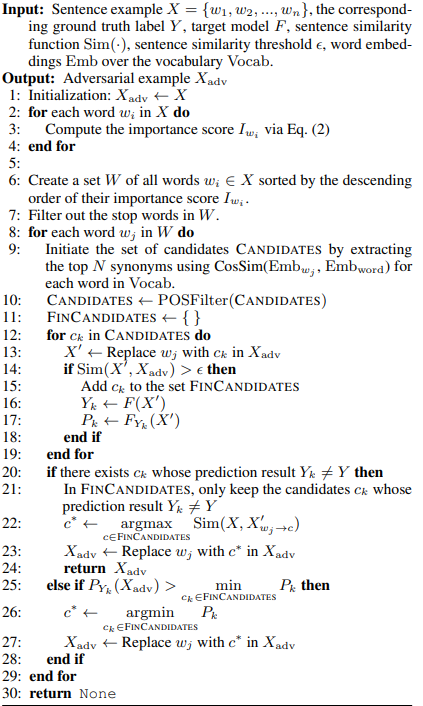

## Preparing some function

In [ ]:
model.load_state_dict(torch.load(os.path.join(COLAB_PATH, "model.pt")))

<All keys matched successfully>

In [ ]:
import pickle
import numpy as np
import os
import nltk
import re

nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

In [ ]:
from typing import List

# function for transform text to input format of BERT
def row_to_tensor(tokenizer, text, clear_text=True):
    tensor = []
    for i in text:
        if clear_text:
            tokens = tokenizer.encode(clear_str(i), add_special_tokens=True)
        else:
            tokens = tokenizer.encode(i, add_special_tokens=True)
        tokens = tokens[:119] + [tokens[-1]] if len(tokens) > 120 else tokens
        tensor.append(torch.LongTensor(tokens))
    tensor = pad_sequence(tensor, batch_first=True, padding_value=0)
    x = torch.LongTensor(tensor)
    return x

# function for doing prediciton
def prediction(model, text: List, clear_text=True):
    with torch.no_grad():
        x = row_to_tensor(tokenizer, text, clear_text).to(device) 
        mask = (x != 0).float()
        outputs = model(x, attention_mask=mask)
    return outputs

## Cosine Similarity matrix

Corpus of words for finding synonims i take from this: https://arxiv.org/pdf/1603.00892.pdf



In [ ]:
idx2word = {}
word2idx = {}

with open(os.path.join(COLAB_PATH, "counter-fitted-vectors.txt"), 'r') as ifile:
    for line in ifile:
        word = line.split()[0]
        if word not in idx2word:
            idx2word[len(idx2word)] = word
            word2idx[word] = len(idx2word) - 1


with open(os.path.join(COLAB_PATH, "mat.txt"), "rb") as fp:
    cos_sim = pickle.load(fp)

## StopWords

Here i wrote fucntion for get set of stop words

In [ ]:
def get_stopwords():
    stop_words = ['a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'ain', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'am', 'among', 'amongst', 'an', 'and', 'another', 'any', 'anyhow', 'anyone', 'anything', 'anyway', 'anywhere', 'are', 'aren', "aren't", 'around', 'as', 'at', 'back', 'been', 'before', 'beforehand', 'behind', 'being', 'below', 'beside', 'besides', 'between', 'beyond', 'both',  'but', 'by', 'can', 'cannot', 'could', 'couldn', "couldn't", 'd', 'didn', "didn't", 'doesn', "doesn't", 'don', "don't", 'down', 'due', 'during', 'either', 'else', 'elsewhere', 'empty', 'enough', 'even', 'ever', 'everyone', 'everything', 'everywhere', 'except',  'first', 'for', 'former', 'formerly', 'from', 'hadn', "hadn't",  'hasn', "hasn't",  'haven', "haven't", 'he', 'hence', 'her', 'here', 'hereafter', 'hereby', 'herein', 'hereupon', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'however', 'hundred', 'i', 'if', 'in', 'indeed', 'into', 'is', 'isn', "isn't", 'it', "it's", 'its', 'itself', 'just', 'latter', 'latterly', 'least', 'll', 'may', 'me', 'meanwhile', 'mightn', "mightn't", 'mine', 'more', 'moreover', 'most', 'mostly',  'must', 'mustn', "mustn't", 'my', 'myself', 'namely', 'needn', "needn't", 'neither', 'never', 'nevertheless', 'next', 'no', 'nobody', 'none', 'noone', 'nor', 'not', 'nothing', 'now', 'nowhere', 'o', 'of', 'off', 'on', 'once', 'one', 'only', 'onto', 'or', 'other', 'others', 'otherwise', 'our', 'ours', 'ourselves', 'out', 'over', 'per', 'please','s', 'same', 'shan', "shan't", 'she', "she's", "should've", 'shouldn', "shouldn't", 'somehow', 'something', 'sometime', 'somewhere', 'such', 't', 'than', 'that', "that'll", 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'thence', 'there', 'thereafter', 'thereby', 'therefore', 'therein', 'thereupon', 'these', 'they','this', 'those', 'through', 'throughout', 'thru', 'thus', 'to', 'too','toward', 'towards', 'under', 'unless', 'until', 'up', 'upon', 'used',  've', 'was', 'wasn', "wasn't", 'we',  'were', 'weren', "weren't", 'what', 'whatever', 'when', 'whence', 'whenever', 'where', 'whereafter', 'whereas', 'whereby', 'wherein', 'whereupon', 'wherever', 'whether', 'which', 'while', 'whither', 'who', 'whoever', 'whole', 'whom', 'whose', 'why', 'with', 'within', 'without', 'won', "won't", 'would', 'wouldn', "wouldn't", 'y', 'yet', 'you', "you'd", "you'll", "you're", "you've", 'your', 'yours', 'yourself', 'yourselves']
    stop_words = set(stop_words)
    return stop_words

In [ ]:
stop_words_set = get_stopwords()

## POS

Get a PoS of the word in sentence

In [ ]:
def get_pos(sent, tagset='universal'):
    '''
    Universal (Coarse) Pos tags has 12 categories
        - NOUN (nouns)
        - VERB (verbs)
        - ADJ (adjectives)
        - ADV (adverbs)
        - PRON (pronouns)
        - DET (determiners and articles)
        - ADP (prepositions and postpositions)
        - NUM (numerals)
        - CONJ (conjunctions)
        - PRT (particles)
        - . (punctuation marks)
        - X (a catch-all for other categories such as abbreviations or foreign words)

    :param sent: list of word strings
    :param tagset: {'universal', 'default'}
    :return: list of pos tags.
    '''
    word_n_pos_list = nltk.pos_tag(sent, tagset=tagset)
    _, pos_list = zip(*word_n_pos_list)
    return pos_list

Function for get filter mask. Original word and New attacking word should be same tag. This step is to assure that the grammar of the text is mostly maintained

In [ ]:
def pos_filter(ori_pos, new_pos_list):
    same = [True if ori_pos == new_pos or (set([ori_pos, new_pos]) <= set(['NOUN', 'VERB']))
            else False
            for new_pos in new_pos_list]
    return same

## Main attack algorithm

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

'''
Use Universal Sentence Encoder to encode the two sentences into high dimensional
vectors and use their cosine similarity score as an approximation of semantic similarity.
'''
class USE(object):
    def __init__(self, cache_path):
        super(USE, self).__init__()
        module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/5"
        self.embed = hub.load(module_url)

    def semantic_sim(self, sents1, sents2):
        sts_encode1 = tf.nn.l2_normalize(self.embed(sents1), axis=1)
        sts_encode2 = tf.nn.l2_normalize(self.embed(sents2), axis=1)
        cosine_similarities = tf.reduce_sum(tf.multiply(sts_encode1, sts_encode2), axis=1)
        clip_cosine_similarities = tf.clip_by_value(cosine_similarities, -1.0, 1.0)
        scores = 1.0 - tf.acos(clip_cosine_similarities)
        return scores

sim_predictor = USE("/")

In [ ]:
from tqdm import tqdm

def attack(text_ls: List, sim_score_threshold=0.5, import_score_threshold=-1,
           min_cos_sim=0.5, max_num_change=100):
    """
    :params text_ls: original text
    :params sim_score_threshold: threshold for checking similarities of two sentence (epsilon)
    :params import_score_threshold: threshold for getting word to perturb
    :params min_cos_sim: threshold for finding synonims
    :params max_num_change: max num for replacing word by synonims in sentence

    :return: [attacked text, changed_word_idx, original label, original probability of label, new probability, Sim(attacked text, original text)]
    """
    # initialize some important value
    len_text = len(text_ls)
    orig_probs = prediction(model, [" ".join(text_ls)], True).squeeze()
    orig_label = torch.argmax(orig_probs)
    orig_prob = orig_probs.max()

    # get POS of original sentence
    pos_ls = get_pos(text_ls)

    # compute importance score of each word
    leave_1_texts = [" ".join(text_ls[:ii] + ["<oov>"] + text_ls[min(ii + 1, len_text):]) for ii in range(len_text)]
    leave_1_probs = prediction(model, leave_1_texts, False)
    leave_1_probs_argmax = torch.argmax(leave_1_probs, dim=-1)
    import_scores = (orig_prob - leave_1_probs[:, orig_label] + (leave_1_probs_argmax != orig_label).float() * (
                leave_1_probs.max(dim=-1)[0] - torch.index_select(orig_probs, 0,
                                                                    leave_1_probs_argmax))).data.cpu().numpy()

    # get words to perturb sorted by importance score 
    words_perturb = []
    for idx, score in sorted(enumerate(import_scores), key=lambda x: x[1], reverse=True):
        if score > import_score_threshold and text_ls[idx] not in stop_words_set:
            words_perturb.append((idx, text_ls[idx]))

    # find synonyms for each word
    words_perturb_idx = [word2idx[word] for idx, word in words_perturb if word in word2idx]
    synonym_words = []
    for idx in words_perturb_idx:
        res = list(zip(*(cos_sim[idx])))
        temp = []
        for idx, ii in enumerate(res[1]):
            if min_cos_sim <= res[0][idx]:
                temp.append(idx2word[ii])
        synonym_words.append(temp)

    synonyms_all = []
    for idx, word in words_perturb:
        if word in word2idx:
            synonyms = synonym_words.pop(0)
            if synonyms:
                synonyms_all.append((idx, synonyms))

    num_changed = 0  # number of replacing word by synonims
    text_colored_ind = set()
    while num_changed < max_num_change:
        text_prime = text_ls[:] if num_changed == 0 else text_cache[:]
        text_cache = text_prime[:]

        for idx, synonyms in tqdm(synonyms_all):
            # replace original word with synonim and change new probabilities 
            new_texts = [" ".join(text_prime[:idx] + [synonym] + text_prime[min(idx + 1, len_text):]) for synonym in synonyms]
            new_probs = prediction(model, new_texts, True)
            new_texts = [x.split() for x in new_texts]

            
            # get Sim(X, X_adv) values
            semantic_sims = sim_predictor.semantic_sim([' '.join(text_ls[:])] * len(new_texts),
                                        list(map(lambda x: ' '.join(x[:]), new_texts)))

            # create mask, where 1 is a word, that change the target class
            new_probs_mask = (orig_label != torch.argmax(new_probs, dim=-1)).data.cpu().numpy().astype(int)

            # get mask, where 1 is good synonym (using synonim Sim(X, X_adv) > epsilon ) 
            new_probs_mask *= (semantic_sims >= sim_score_threshold).numpy().astype(int)

            # get mask where 1 is compatible pos
            synonyms_pos_ls = [get_pos(new_text[max(idx - 4, 0):idx + 5])[min(4, idx)]
                                if len(new_text) > 10 else get_pos(new_text)[idx] for new_text in new_texts]
            pos_mask = np.array(pos_filter(pos_ls[idx], synonyms_pos_ls)).astype(int)
            new_probs_mask *= pos_mask

            if np.sum(new_probs_mask) > 0:
                # if we after filtering we have candidates, then return it
                text_prime[idx] = synonyms[(new_probs_mask * semantic_sims).numpy().argmax()]
                text_colored_ind.add(idx)
                return [text_prime, text_colored_ind, orig_label, orig_prob,
                        prediction(model, [' '.join(text_prime)], False),
                        sim_predictor.semantic_sim([' '.join(text_ls)], [' '.join(text_prime)])]
            else:
                # if we after filtering we have no candidates, then take this value, which 
                # decrease as much as possible our probability of original class
                new_label_probs = new_probs[:, orig_label] + torch.from_numpy(
                        (semantic_sims < sim_score_threshold).numpy().astype(int) * 10 + (1 - pos_mask).astype(float) * 10).float().cuda()
                new_label_prob_min, new_label_prob_argmin = torch.min(new_label_probs, dim=-1)

                if new_label_prob_min < orig_prob and text_prime[idx] != synonyms[new_label_prob_argmin]:
                    text_prime[idx] = synonyms[new_label_prob_argmin]
                    text_colored_ind.add(idx)

            text_cache = text_prime[:]
            num_changed += 1

    return [text_prime, text_colored_ind, orig_label, orig_prob,
            prediction(model, [' '.join(text_prime)], False),
            sim_predictor.semantic_sim([' '.join(text_ls)], [' '.join(text_prime)])]

# Get aversarial results

In [ ]:
df_train

,id,comment_text,toxic,non_toxic,length
87390,e9d02663806200df,References\n\nExternal links\nIn the Name of J...,0,1,41
51236,8917087c09ba54f0,We were just kidding \n\nSorry about all of th...,0,1,32
28774,4c3e3051916a2438,; good point. – (T • C),0,1,7
126187,a2d813060f4f43ad,South America \nCamino Real in Peru may be a g...,0,1,43
144034,06e7b077fea4f093,"Hello. Firstly, I would like to apologize for ...",0,1,164
...,...,...,...,...,...
63092,a8cea14350c1fc42,Go hang yoursef lazy fu... \n\n Go hang yourse...,1,0,10
91604,f4ef5dc180fafcba,Infoboxes should be piled in the Grand Canyon ...,1,0,22
114167,62cfc3bf27e0bf1d,haunted angel sucks cock every night,1,0,6
123187,9306a5d101a13438,"""\na """"demon-possessed pedophile"""" [pedophile ...",1,0,8


Here I take 200 toxic samples to attack them. 

In [ ]:
dataset_to_attack = df_train[df_train["toxic"] == 1].sample(
                200, random_state=199, replace=False
            )

In [ ]:
from IPython.display import clear_output 

data = {}
columns = ["Original Label", "Attacked Label", "Original", "Attacked",
           "Original target probability", "Attacked target probability",
           "Similarity of Sentences", "Is Attack succeed?"]

for index, row in tqdm(dataset_to_attack.iterrows()):
    orig_text = clear_str(row["comment_text"]).split()
    new_text, idx, orig_label, orig_prob, new_prob, similarity = attack(orig_text[:120], max_num_change=30)

    for i in idx:
        orig_text[i] = f"<font color = green>{orig_text[i]}</font>"
        new_text[i] = f"<font color = red>{new_text[i]}</font>"
        is_success = "Yes" if torch.argmax(new_prob.squeeze()) != orig_label.item() else "No"

    data[index] = [orig_label.item(), torch.argmax(new_prob.squeeze()).item(),
                   " ".join(orig_text), " ".join(new_text),
                  orig_prob.item(), new_prob[0].tolist()[orig_label],
                  similarity.numpy()[0], is_success]
    clear_output()

200it [17:39,  5.30s/it]


In [ ]:
result = pd.DataFrame.from_dict(data, orient='index', columns=columns)
result.to_csv(COLAB_PATH + "res.csv")

In [ ]:
from IPython.core.display import display, HTML
display(
    HTML(result.to_html(escape=False))
)

,Original Label,Attacked Label,Original,Attacked,Original target probability,Attacked target probability,Similarity of Sentences,Is Attack succeed?
98109,1,1,"i think stupidity results in hating people for their race , that still does n't mean they do n't hate them .","i think daft result in hating persons for their race , that nonetheless wantto n't mean they suis n't hate them .",0.909623,0.605400,0.504257,No
112135,1,1,"why do n't you go to hell , how 's that fool ! i do n't like liars ! ! ! i hate liars ! ! ! and if change this shit one more time , i will report your ass ! ! ! ! ! ! ! ! ! !","why fait n't you go to christ , how 's that nincompoop ! i do n't liked liars ! ! ! i dislikes liars ! ! ! and if changes this geez one more intervals , i hope report your cul ! ! ! ! ! ! ! ! ! !",0.972563,0.730987,0.500941,No
77771,1,0,"now y can leader the china pigs , taiwan not needchian pigs .","now y can chairperson the china pigs , taiwan not needchian pigs .",0.683600,0.368549,0.716303,Yes
30740,1,0,"more youtube i f cking hate those chain letters on youtube , pisses me off everytime i see one . like this one 'this is a true thing that can happen ! its not a chain letter ! its kinda scary at first but it really works ! ! paste this message into 3 comments and press atl f4 and your crushes name will appear on your screan ! ! ! is so weird this is a true thing that can happen ! its not a chain letter ! its kinda scary at first but it really works ! ! paste this message into 3 comments and press atl f4 and your crushes name will appear on your screan ! ! ! is so weird' retards .","more youtube i f cking disliked those chain letters on youtube , humid me off everytime i see one . like this one 'this is a sincere thing that can happen ! its not a chain letter ! its kinda scary at first but it really works ! ! attach this message into 3 comments and press atl f4 and your excels name will appear on your screan ! ! ! is so weird this is a true thing that can happen ! its not a chain letter ! its kinda scary at first but it really works ! ! macaroni this announcements into 3 comments and press atl f4 and your crushes name will appear on your screan !",0.945806,0.480684,0.675839,Yes
75776,1,1,please shoot yourself please put yourself out of your misery . either shoot or hang yourself you depressed freak .,please stem yourself please placing yourself out of your distressing . either offed or hang yourself you depression aberration .,0.958606,0.831406,0.502315,No
16057,1,0,"'cause if fox did that , then they're a bunch of greedy idiots no shit sherlock , why do you think they make comics ? cause they like kids ?","'cause if fox did that , then they're a fanfare of keen dunce no sodding sherlock , why suis you think they make comics ? owing they like junior ?",0.968731,0.474248,0.521141,Yes
97197,1,1,) hey mother fucking asshole hows going . i wanna rape ur mother . and will post that video youporn dot com or matacafe or pornotube dot com . u tell me wher i should upload it . hehehehehehehehehehheheheehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehhehehehehehehehehe r rapeing ur mother will be shaggadelic baby ( as astin powers say,) hey mommy shagged asshole hows going . i wanna infractions ur mother . and will post that video youporn dot com or matacafe or pornotube dotted com . u tell me whe i should uploading it . hehehehehehehehehehheheheehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehehhehehehehehehehehe r rapeing cant mom wanna worden shaggadelic bub ( as astin faculties talk,0.965022,0.860176,0.500291,No
137962,1,0,your mom is my slave and your father is my bitch you all shall bow down to me and your mothers will suck my balls . your father is my slave and i will drive him into the ground with my forhead . as you look upo

Here you can see how many success attack I made 

In [ ]:
result["Is Attack succeed?"].value_counts()

Yes    123
No      77
Name: Is Attack succeed?, dtype: int64